# 이 문서의 개요
이 문서는 LMS에 기록된 각종 메타데이터를 이용하여 우리 대학 학생들의 행동을 지수화하여 직무능력평가 및 역량평가 결과 (성적)를 예측할 수 있는 모형 개발 스크립트를 담고 있습니다.

이 문서는 전체적으로 셀 (cell) 단위로 작성되어 있습니다. 각 셀은
- 스크립트 코드를 설명하는 내용
- 해당 설명내용이 지칭하는 스크립트 코드

형식으로 구성되어 있습니다. 특히 학생의 데이터를 읽어들여 전반적인 패턴을 먼저 검토한 후, 적절한 데이터를 이용하여 예측모형을 학습시키도록 짜여있습니다.

이 문서에서 활용하는 모델링 스크립트는 ensemble modelling (앙상블 모델링) 기법 중 Extreme Gradient Boosting (XGBoost)을 활용합니다. XGBoost의 개념과 방식에 대한 설명은 다음 링크를 참고 바랍니다.
- XGBoost 알고리즘 개념 이해: https://bcho.tistory.com/1354
- Python환경에서 XGBoost libary 설명: https://xgboost.readthedocs.io/en/latest/
- Chen et al., 2016. KDD '16: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data MiningAugust 2016 Pages 785–794 https://doi.org/10.1145/2939672.2939785

---



# 1. 모델링 환경 준비하기
이 섹션은 Ensemble algorithm 중 Boosting 기법을 활용하는 XGBoost (Extreme Gradient Boost)를 이용하여 모형을 개발하는 환경을 준비하는 과정입니다. 

## 1.1. Library importing for the pipeline works
XGBoost 모형 개발과 데이터 분석에 필요한 각종 python library를 불러서 이 노트북에 준비시키는 스크립트입니다.

- 주의> 일부 library는 Google Colaboratory 환경에서는 스크립트를 실행시킬 때마다 !pip install [library] 를 실행해서 환경구축한 뒤 importing해주어야 합니다. 예를 들면 shap 은 매번 설치가 필요합니다. 만약 이 스크립트를 jupyter notebook에서 실행시킨다면 한 번 pip로 설치했다면 importing만 해도 됩니다.

## 1.2. Google Drive mounting
이 스크립트를 Google Colaboratory에서 실행시킬 경우, Google Drive를 mount해서 이 노트북에 준비시켜야 합니다. 1.2.는 이 과정을 수행합니다.
- 현재 작성된 스크립트는 Google Drive의 공유드라이브를 이용하도록 해 두었습니다.

In [ ]:
!pip install shap

In [ ]:
# 1.1. Library importing for the pipeline works

##-------------------------------------------------------------------------------
## 아래는 이 스크립트 파일 전체의 기능을 활용하기 위해 불러오는 다양한
## library 목록입니다.
##-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
#서버 작업할당 라이브러리 (likely to torque)
#
# 2021.12.19에 v0.9 스크립트에서 mlxtend의 sequential feature selector 기능이
# joblib을 제대로 호출하지 못하는 현상이 발생하였음. 원인은 이 기능을 제공하는
# sklearn에서 joblib 기능을 제거하였기 때문임. 따라서, 바로 아래 스크립트처럼
# 일반적인 joblib을 호출해서 sklearn의 joblib으로 덧씌워서 작동하도록
# 수정하였음.

import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
#-------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import csv
import xgboost
import matplotlib
import matplotlib.pyplot as plt
import warnings
import pickle
import os
import seaborn as sns
#import shap
import scipy.stats as st
from pandas.plotting import scatter_matrix
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from google.colab import drive
from google.colab import files
from joblib import dump
from joblib import load
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from tqdm import tqdm
from tqdm import trange
from sklearn.metrics import r2_score
from functools import reduce
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection
import statsmodels.api as sm

##-------------------------------------------------------------------------------
## 아래의 library 목록은 tensorflow를 이용하여 deep learning을 구축할 때
## 사용하는 것들입니다. 현재 스크립트에서는 사용하지 않으므로 주석처리
## 해 둔 상태입니다.
##-------------------------------------------------------------------------------
#import xlsxwriter
# import torch
# import torchvision
# import torch.nn

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 1.2. Google Drive mounting

##-------------------------------------------------------------------------------
## 구글드라이브를 데이터 저장소로 활용하기 위해 mount하는 스크립트입니다.
## 필요에 따라 작업용 자료가 저장된 폴더명을 수정하여 사용하십시오.
##-------------------------------------------------------------------------------
from google.colab import drive
from google.colab import files

mount_dir = '/content/gdrive/' 
drive.mount(mount_dir)
mydrive_dir = mount_dir + 'MyDrive/'
dongju_data_mining_dir = mount_dir + 'Shareddrives/DDM_modelling/XGBoost/Core_indices_2021/'

Mounted at /content/gdrive/


# 2. 데이터 불러오기
## 2.1. Loading data file
XGBoost를 이용해서 분석할 수 있도록 Google Drive에 저장해 놓은 MS Excel 형식의 데이터 파일을 읽어옵니다.

## 2.2. Prerocessing of the data
이 스크립트는 필요할 경우에만 사용합니다.

일부 데이터는 루트, 로그 등을 적용하여 데이터를 변환한 뒤 모형에서 사용할 때 더 나은 결과를 얻을 수 있습니다. 이 스크립트를 실행시키면 최초에 불러온 데이터에 각종 전처리가 완료된 데이터를 추가해줍니다.
- 주의> 데이터를 이용하여 분석할 때는 가급적 결측치가 없도록 준비하는 것이 좋습니다. 결측치가 있다면 Excel 데이터를 준비하실 때 결측치를 평균 혹은 여러 가지 적합한 방식으로 교체하신 뒤 분석을 진행하시기를 권합니다.

In [ ]:
# 2.1. Loading data file

##-------------------------------------------------------------------------------
## 구글드라이브에 저장되어 있는 데이터파일 (엑셀파일)을 읽어서, 스크립트 속에서
## 사용할 df라는 data object에 저장하는 스크립트입니다.
##-------------------------------------------------------------------------------

df=pd.read_excel(dongju_data_mining_dir+"Employment_rates_2021_XGBoost_modelling_reduced_1m_divided.xlsx", index_col=0)
df.head()

## ------------------------------------------------------------------------------------------------
## 아래는 numpy 기능으로 자동 생성되는 index를 이용해서 data(dataframe)를
## 무작위로 뒤섞는 기능입니다. XGBoost에서 무작위로 섞은 데이터를 집어넣기 위해 준비했으나,
## training 데이터 준비과정에서 데이터 shuffle이 가능하므로 이 스크립트는 주석처리 해 두었습니다.
## 만약 무작위 처리할 데이터의 특정 column을 인덱스로 사용할 경우 이 기능은 사용하지 마십시오.
## ------------------------------------------------------------------------------------------------

# df=data.iloc[np.random.permutation(data.index)].reset_index(drop=True)

## ------------------------------------------------------------------------------------------------
## 아래는 분석데이터가 csv형태로 저장되어 있을 때 사용할 수 있는 기능입니다.
## 데이터가 csv 형태가 아니라면 사용하지 않습니다.
## ------------------------------------------------------------------------------------------------

# f=open(dongju_data_mining_dir+"mulgum_testdata.csv",'r',encoding='utf-8')
#rdr=csv.reader(f)
#for line in rdr:
#  print(line)
#f.close()

Student_participation_rates_to_ODC  ...  Employment_rates
codes                                      ...                  
C001                                 5.73  ...              71.1
C002                                 1.84  ...              64.7
C003                                 0.00  ...              66.6
C004                                 1.43  ...              78.7
C005                                 0.00  ...              83.0

[5 rows x 22 columns]

In [ ]:
# 2.2. Preprocessing of the data

##-------------------------------------------------------------------------------
## 주의!! 이 스크립트 전체는 <<필요할 때>>만 사용합니다.
##
## 엑셀파일에서 읽어들인 데이터들을 이용해서 루트, 자연로그, 지수함수 처리하여
## 별도의 입력변수를 추가로 더 만드는 기능입니다.
##-------------------------------------------------------------------------------

## sqrt 처리하기
df_sqrt = np.sqrt(df)
df_sqrt.columns = [str(col) + '_sqrt' for col in df_sqrt.columns]

## natural log 처리하기
df_log = np.log(df + 1)
df_log.columns = [str(col) + '_log' for col in df_log.columns]
df_log.head()

## exp 처리하기
#df_exp = np.exp(df)
#df_exp.columns = [str(col) + '_exp' for col in df_exp.columns]
#df_exp.head()

# 생성한 전처리 데이터들을 rawdata df에 붙이기
dfs = [df, df_sqrt, df_log]
df = reduce(lambda left,right: pd.merge(left,right,on='Codes'), dfs)
df.head()

#result1=pd.merge(data, sqrt_data, left_on=data.index, right_on=data.index)  # 두 개의 df를  merge할 때 사용하는 스크립트

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


Student_participation_rates_to_ODC  ...  Employment_rates_log
Codes                                      ...                      
C001                                 5.73  ...              4.278054
C002                                 1.84  ...              4.185099
C003                                 0.00  ...              4.213608
C004                                 1.43  ...              4.378270
C005                                 0.00  ...              4.430817

[5 rows x 186 columns]

# 데이터 특성 탐색하기
## 3.1. Investigation of data distribution
불러온 데이터 속의 각종 입력자료들이 갖는 분포상태를 히스토그램 형식으로 보여줍니다.

## 3.2. Investigation of data density
3.1.과 비슷한 결과를 보여주지만, 데이터의 분포상태를 밀도 형태로 보여줍니다.

## 3.3. Natural log transformation and distirbution pattern investigation
데이터를 히스토그램으로 분석할 때 보면 간혹 1-2개 클래스에 상당량의 데이터가 집중되는 경우가 있습니다. 대체로 log-normal한 분포를 보일 때 이런 현상이 나타나며, 이런 데이터는 "높은 값을 보이는 경우는 별로 없고 대체로 평균보다 낮은 일정 수준의 값을 보여주는 데이터가 많을 때" 발생합니다. 예를 들면, 특정 교과목이 너무 어려워서, 이 교과목을 이수한 학생들의 점수가 너무 낮은 수준에서 상당히 많이 분포하고 고득점을 받은 학생은 점점 적어지는 경우입니다 (아주 낮은 점수를 받은 학생이 많은 것은 아닌 상황). 이런 상황이 있는지 확인하기 위해 입력데이터 전체를 자연로그 처리한 뒤 히스토그램을 그리는 스크립트입니다.

## 3.4. Correlation matrix
data 속에 포함된 모든 변수들의 상관성을 분석하여 하나의 매트릭스로 만드는 스크립트입니다. 통계적 유의성은 나타나지 않고, 상관성이 강할 수록 글자 주변 색이 진해지도록 설정하였습니다. 통계적 유의성의 검토가 필요할 경우 아래의 하이퍼링크를 클릭해서 critical values for pearson correlation table을 참조하시기 바랍니다.
https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/table-of-critical-values-pearson-correlation/

## 3.5. Investigation of the relationship between the input features
불러온 데이터 속의 모든 input feature간의 상관성을 XY plot 형태로 보여줍니다. 3.4. 상관성 테이블은 단순한 관계의 정도만 보여주지만, XY plot을 그려보면 좀 더 명확한 관계형태를 파악할 수 있습니다.

## 3.6. Fitting data distribution
이 스크립트는 특정 입력변수의 분포를 가장 잘 설명하는 fitness 함수를 추정하고, 그 함수를 주어진 데이터 근사시키는 기능입니다. 상당히 다양한 함수를 활용하는데, 데이터 숫자가 1만 행을 넘어가면 모든 함수를 근사시키는데 매우 긴 시간이 필요합니다. 따라서, 히스토그램을 보고 적합해보이는 fitness 함수를 몇 개 선별해서 근사시키는 것이 효율적입니다.

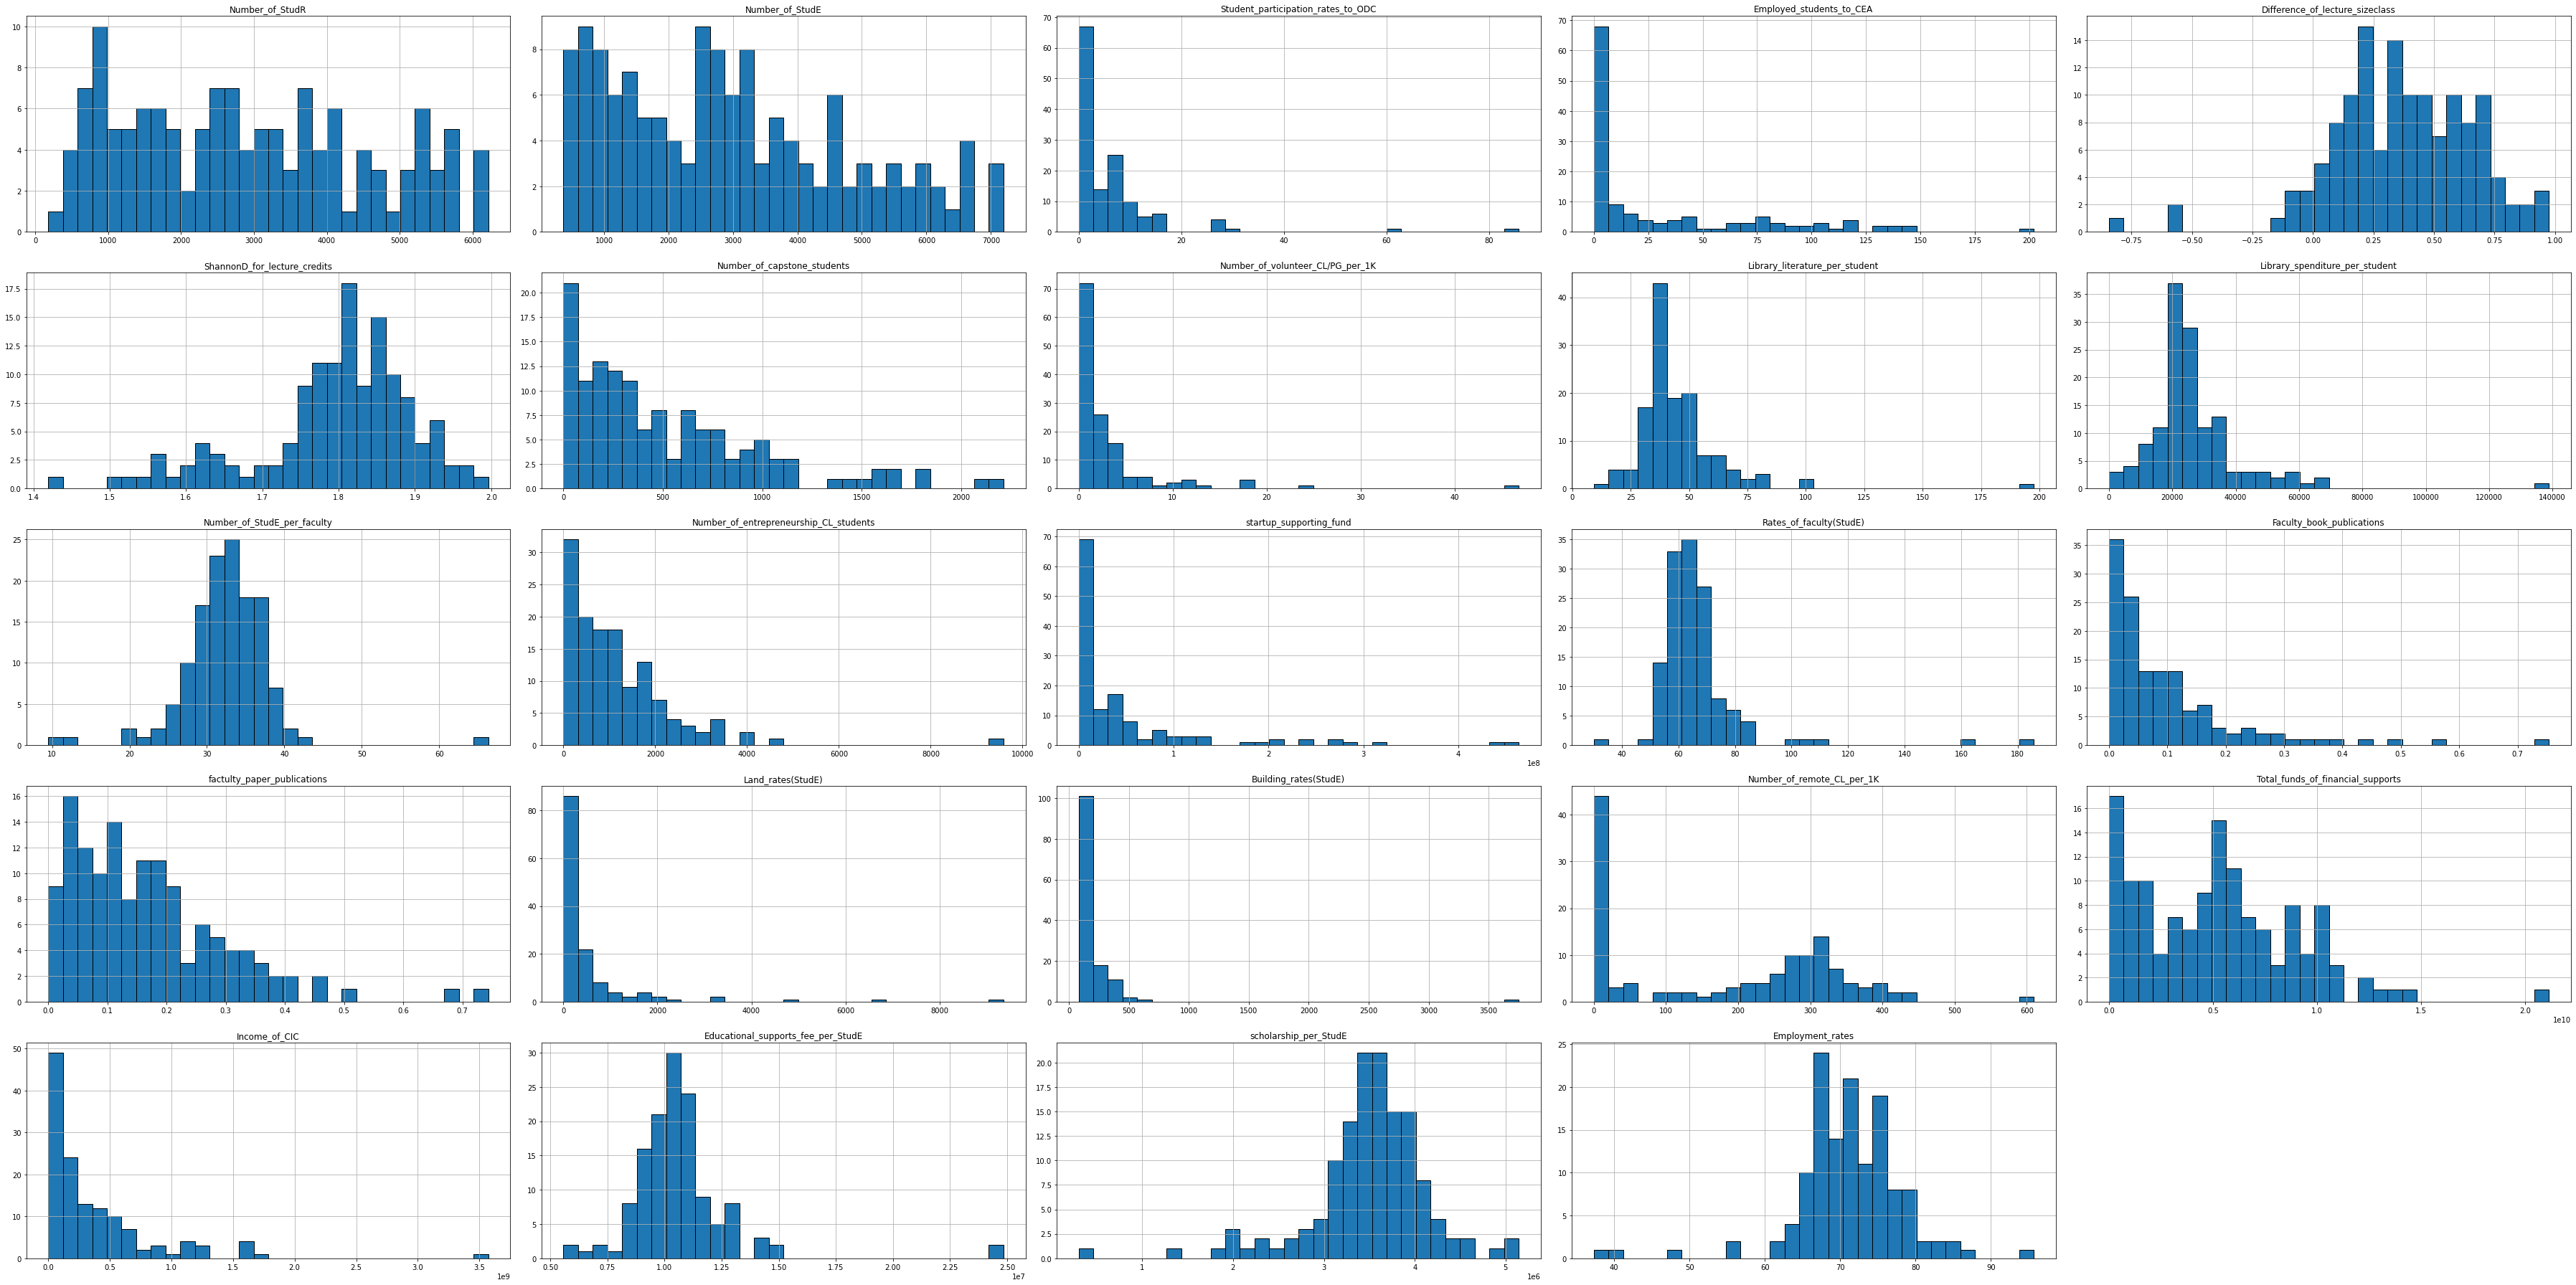

In [ ]:
# 3.1. Investigation of data distribution

##-------------------------------------------------------------------------------
## 데이터 각각의 히스토그램을 그리는 스크립트입니다.
## 분석 전에 데이터의 분포를 확인하는데 사용합니다.
##-------------------------------------------------------------------------------

df.hist(figsize=(50,25), bins=30, ec="k")
plt.tight_layout()
plt.show()

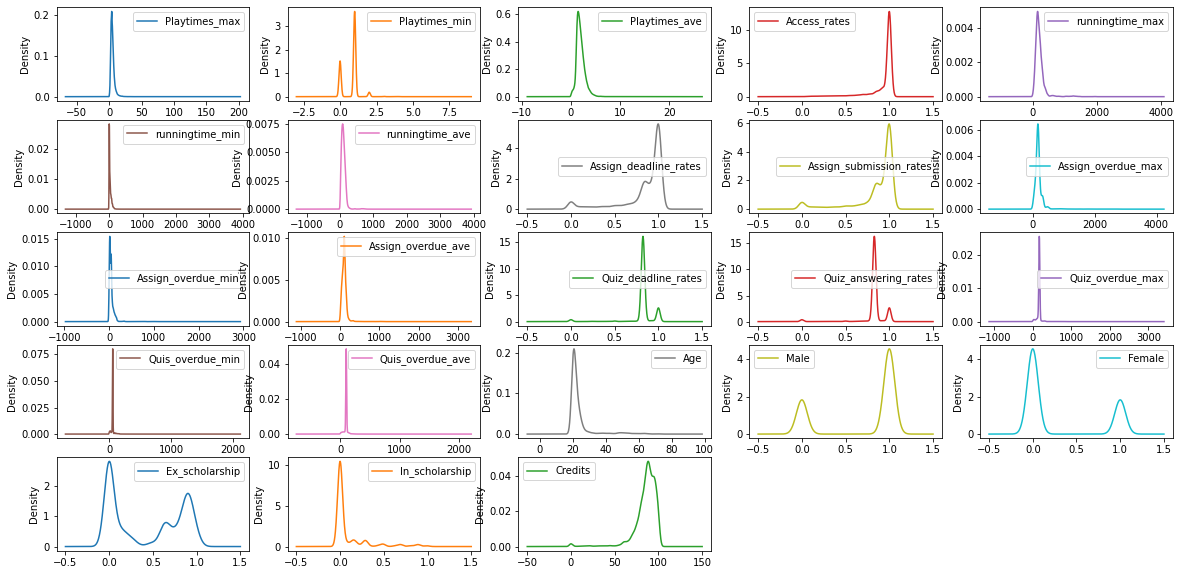

In [ ]:
# 3.2. Investigation of data density

##-------------------------------------------------------------------------------
## 각 데이터의 kernel density estimation (KDE)를 실시하는 스크립트입니다.
## 히스토그램과 비슷한 결과가 나오지만, X축의 클래스 크기에 비의존적으로
## 상세하게 각 데이터의 분포상태를 확인할 수 있습니다.
##-------------------------------------------------------------------------------

df.plot(kind='density', subplots=True, layout=(5,5), sharex=False, figsize=(20,10))
plt.show()

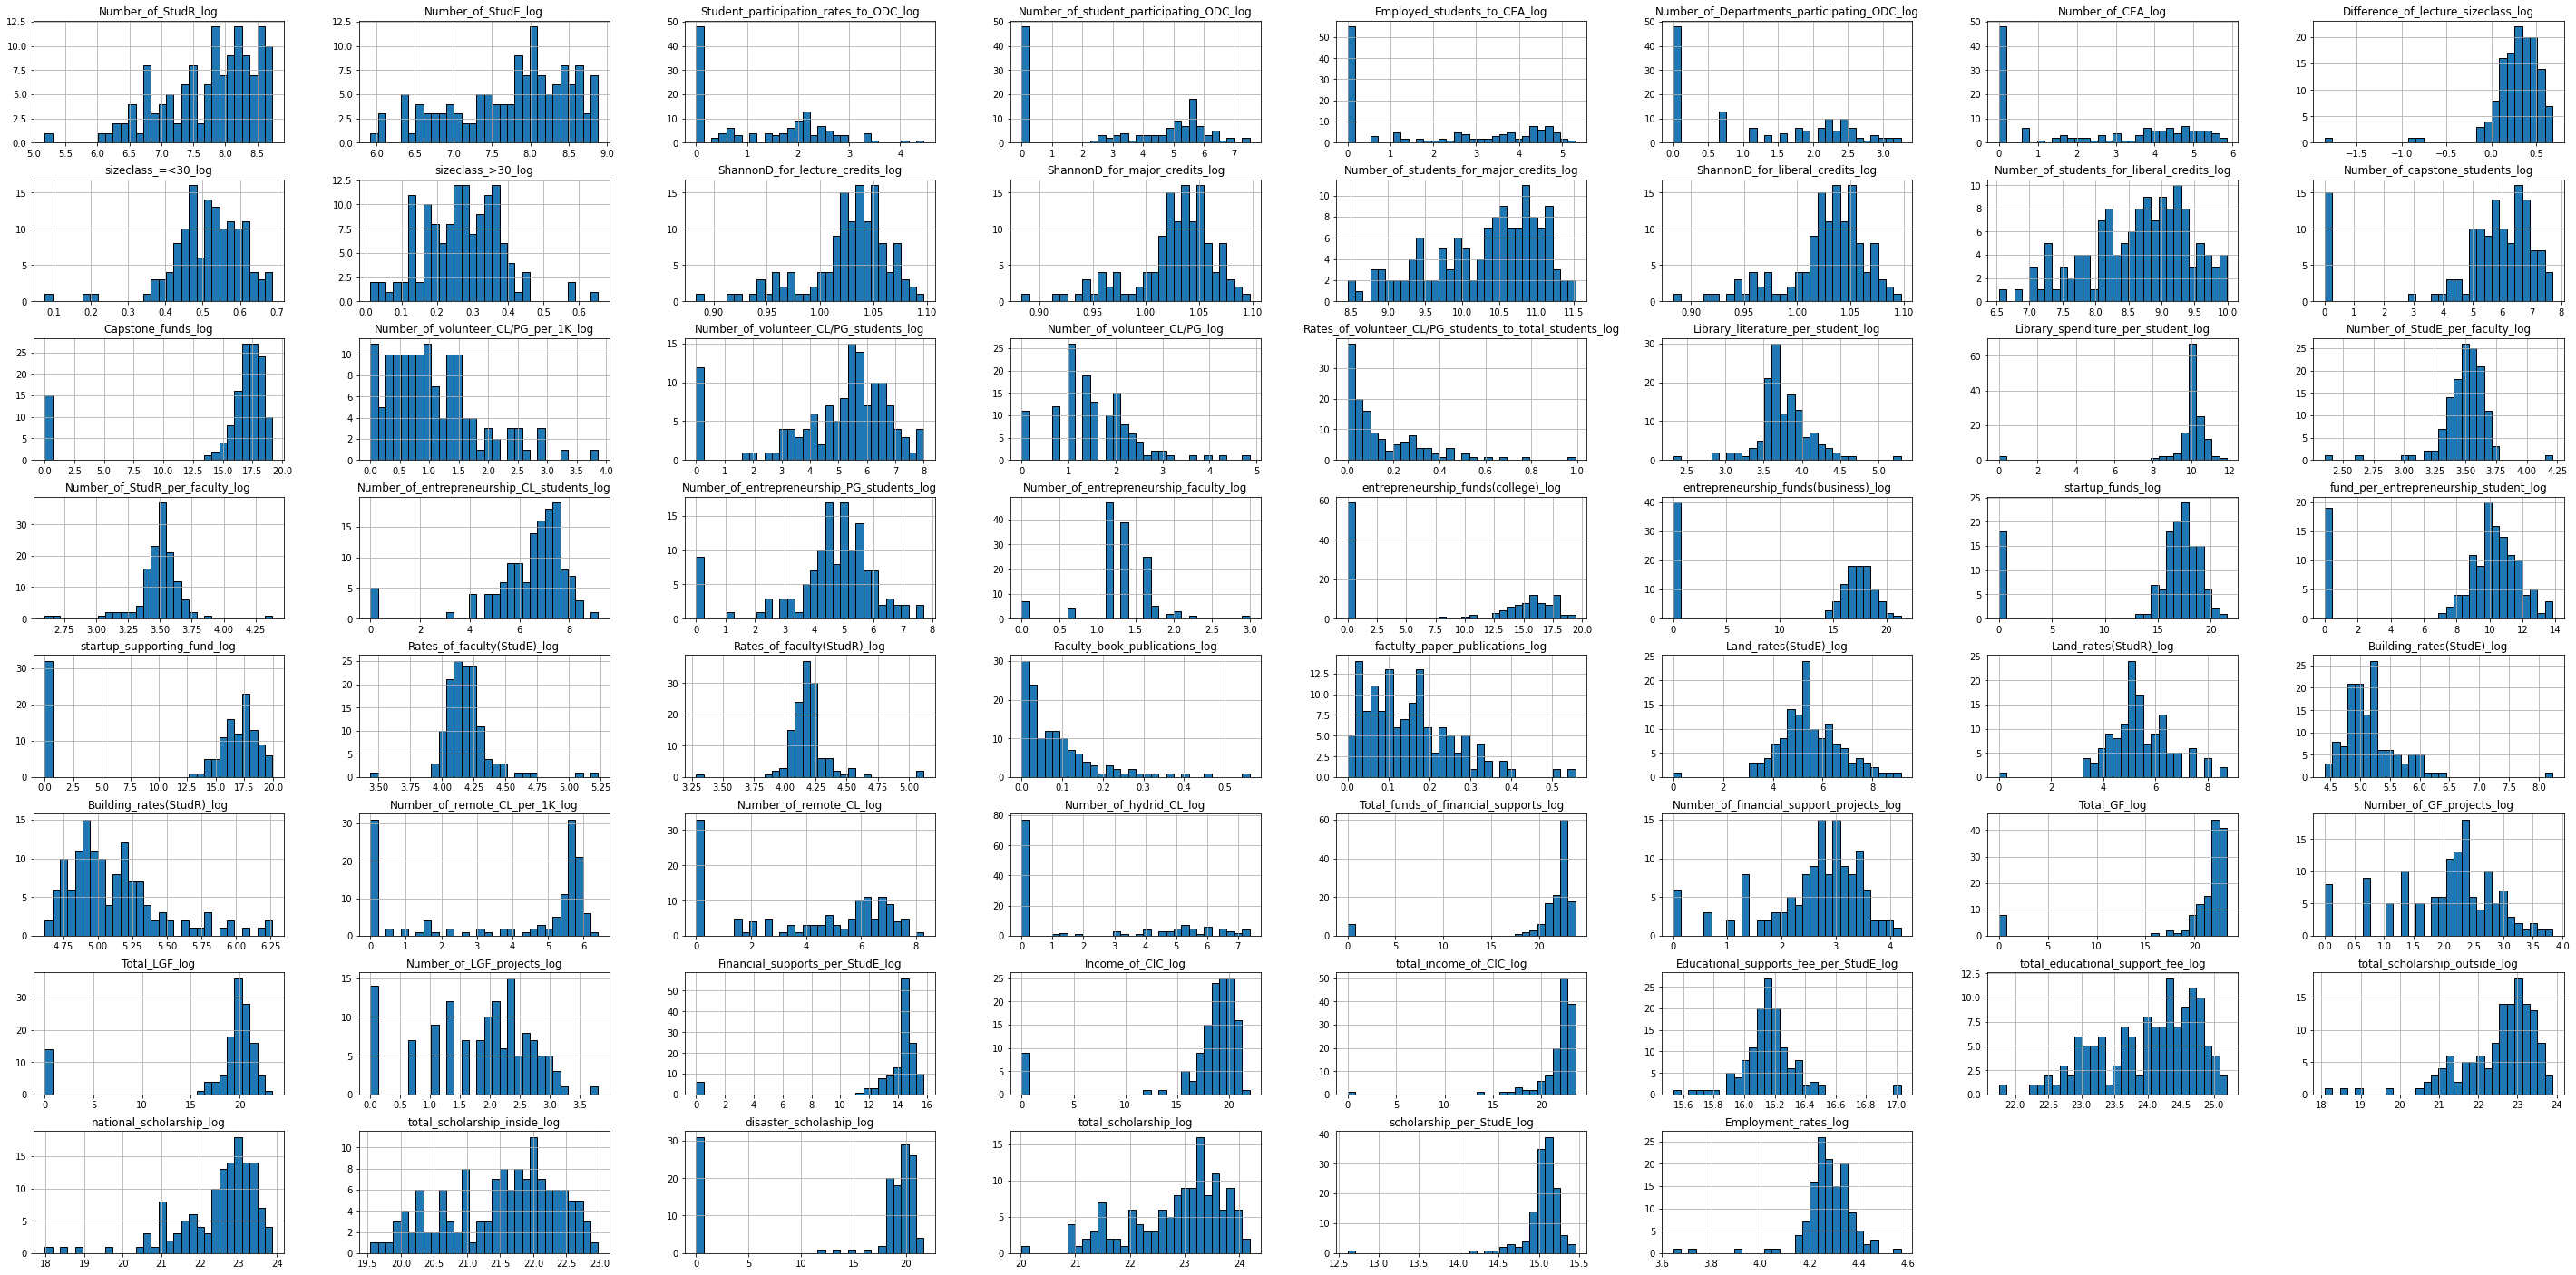

In [ ]:
## 3.3. Natural log transformation and distirbution pattern investigation

##-------------------------------------------------------------------------------
## 입력데이터에 자연로그를 취한 결과로 히스토그램을 그립니다.
## 히스토그램 결과상 막대들이 한쪽으로 치우친 상태라면, 로그처리하면
## 값은 작아지고 작은 값은 커지면서 막대들이 좀 더 가운데에서 보기좋게
## 정렬되는 경향이 있습니다.
##-------------------------------------------------------------------------------

df_log = np.log(df + 1)
df_log.columns = [str(col) + '_log' for col in df_log.columns]

df_log.hist(figsize=(50,25), bins=30, ec="k")
#plt.tight_layout()
plt.show()

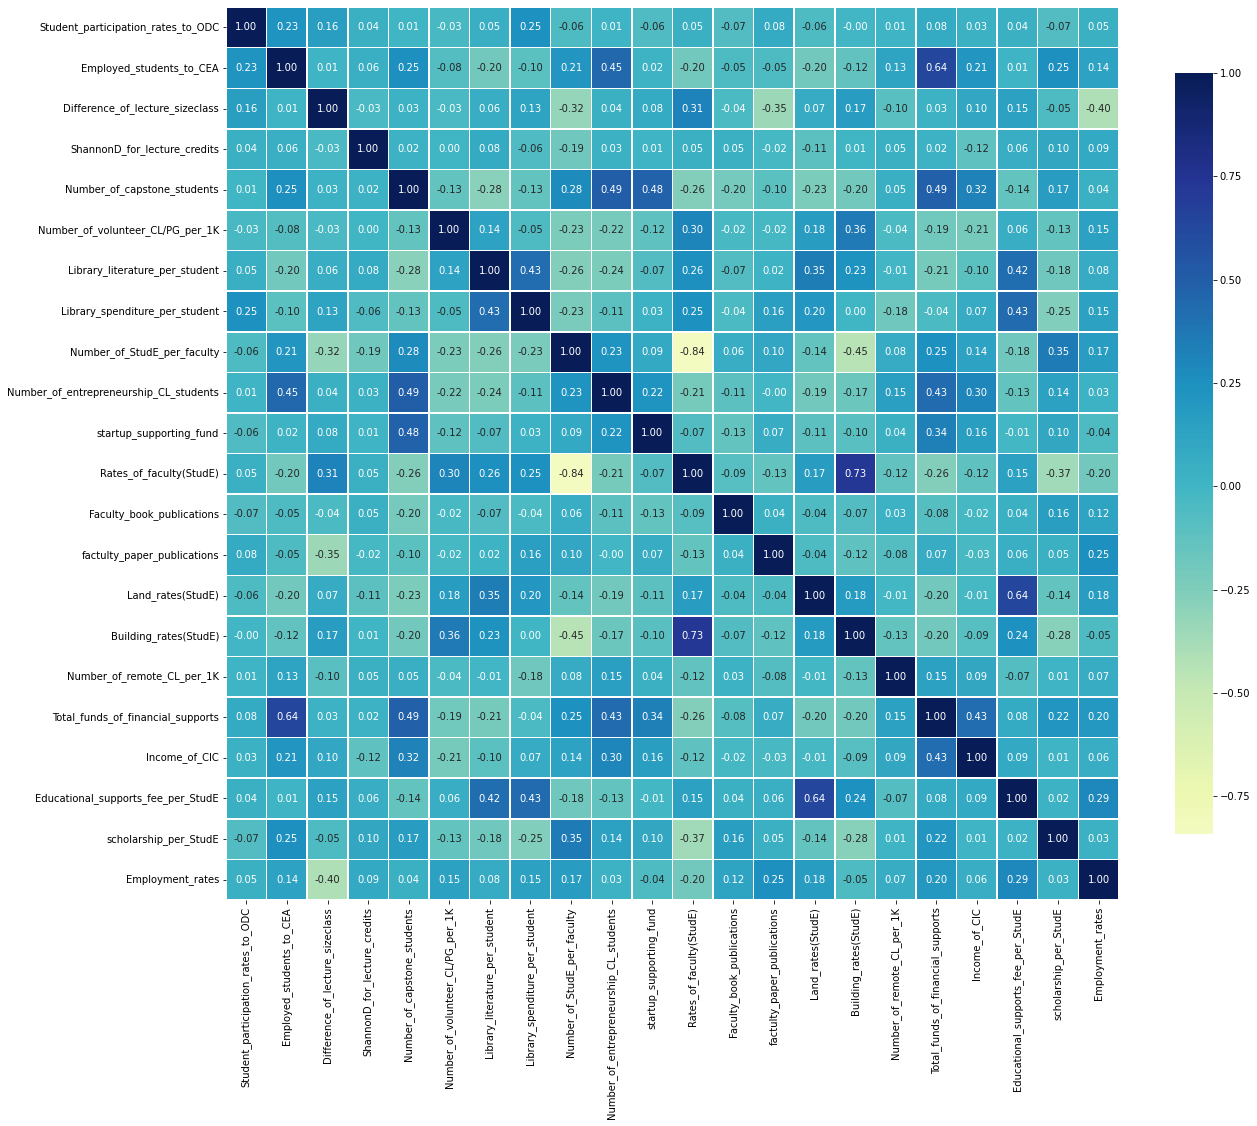

In [ ]:
## 3.4. Correlation matrix

##-------------------------------------------------------------------------------
## df라는 객체 속에 들어 있는 모든 종류의 데이터를 이용해서, 또 다른
## 변수들에 대해 갖는 bivariate correlation 값들을 matrix 형태로 보여줍니다.
## 통계적 유의성은 여기서는 보여주지 않고, 상관성이 양 혹은 음의 방향으로
## 높을 수록 진한 색으로 표현됩니다.
##-------------------------------------------------------------------------------

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(df)

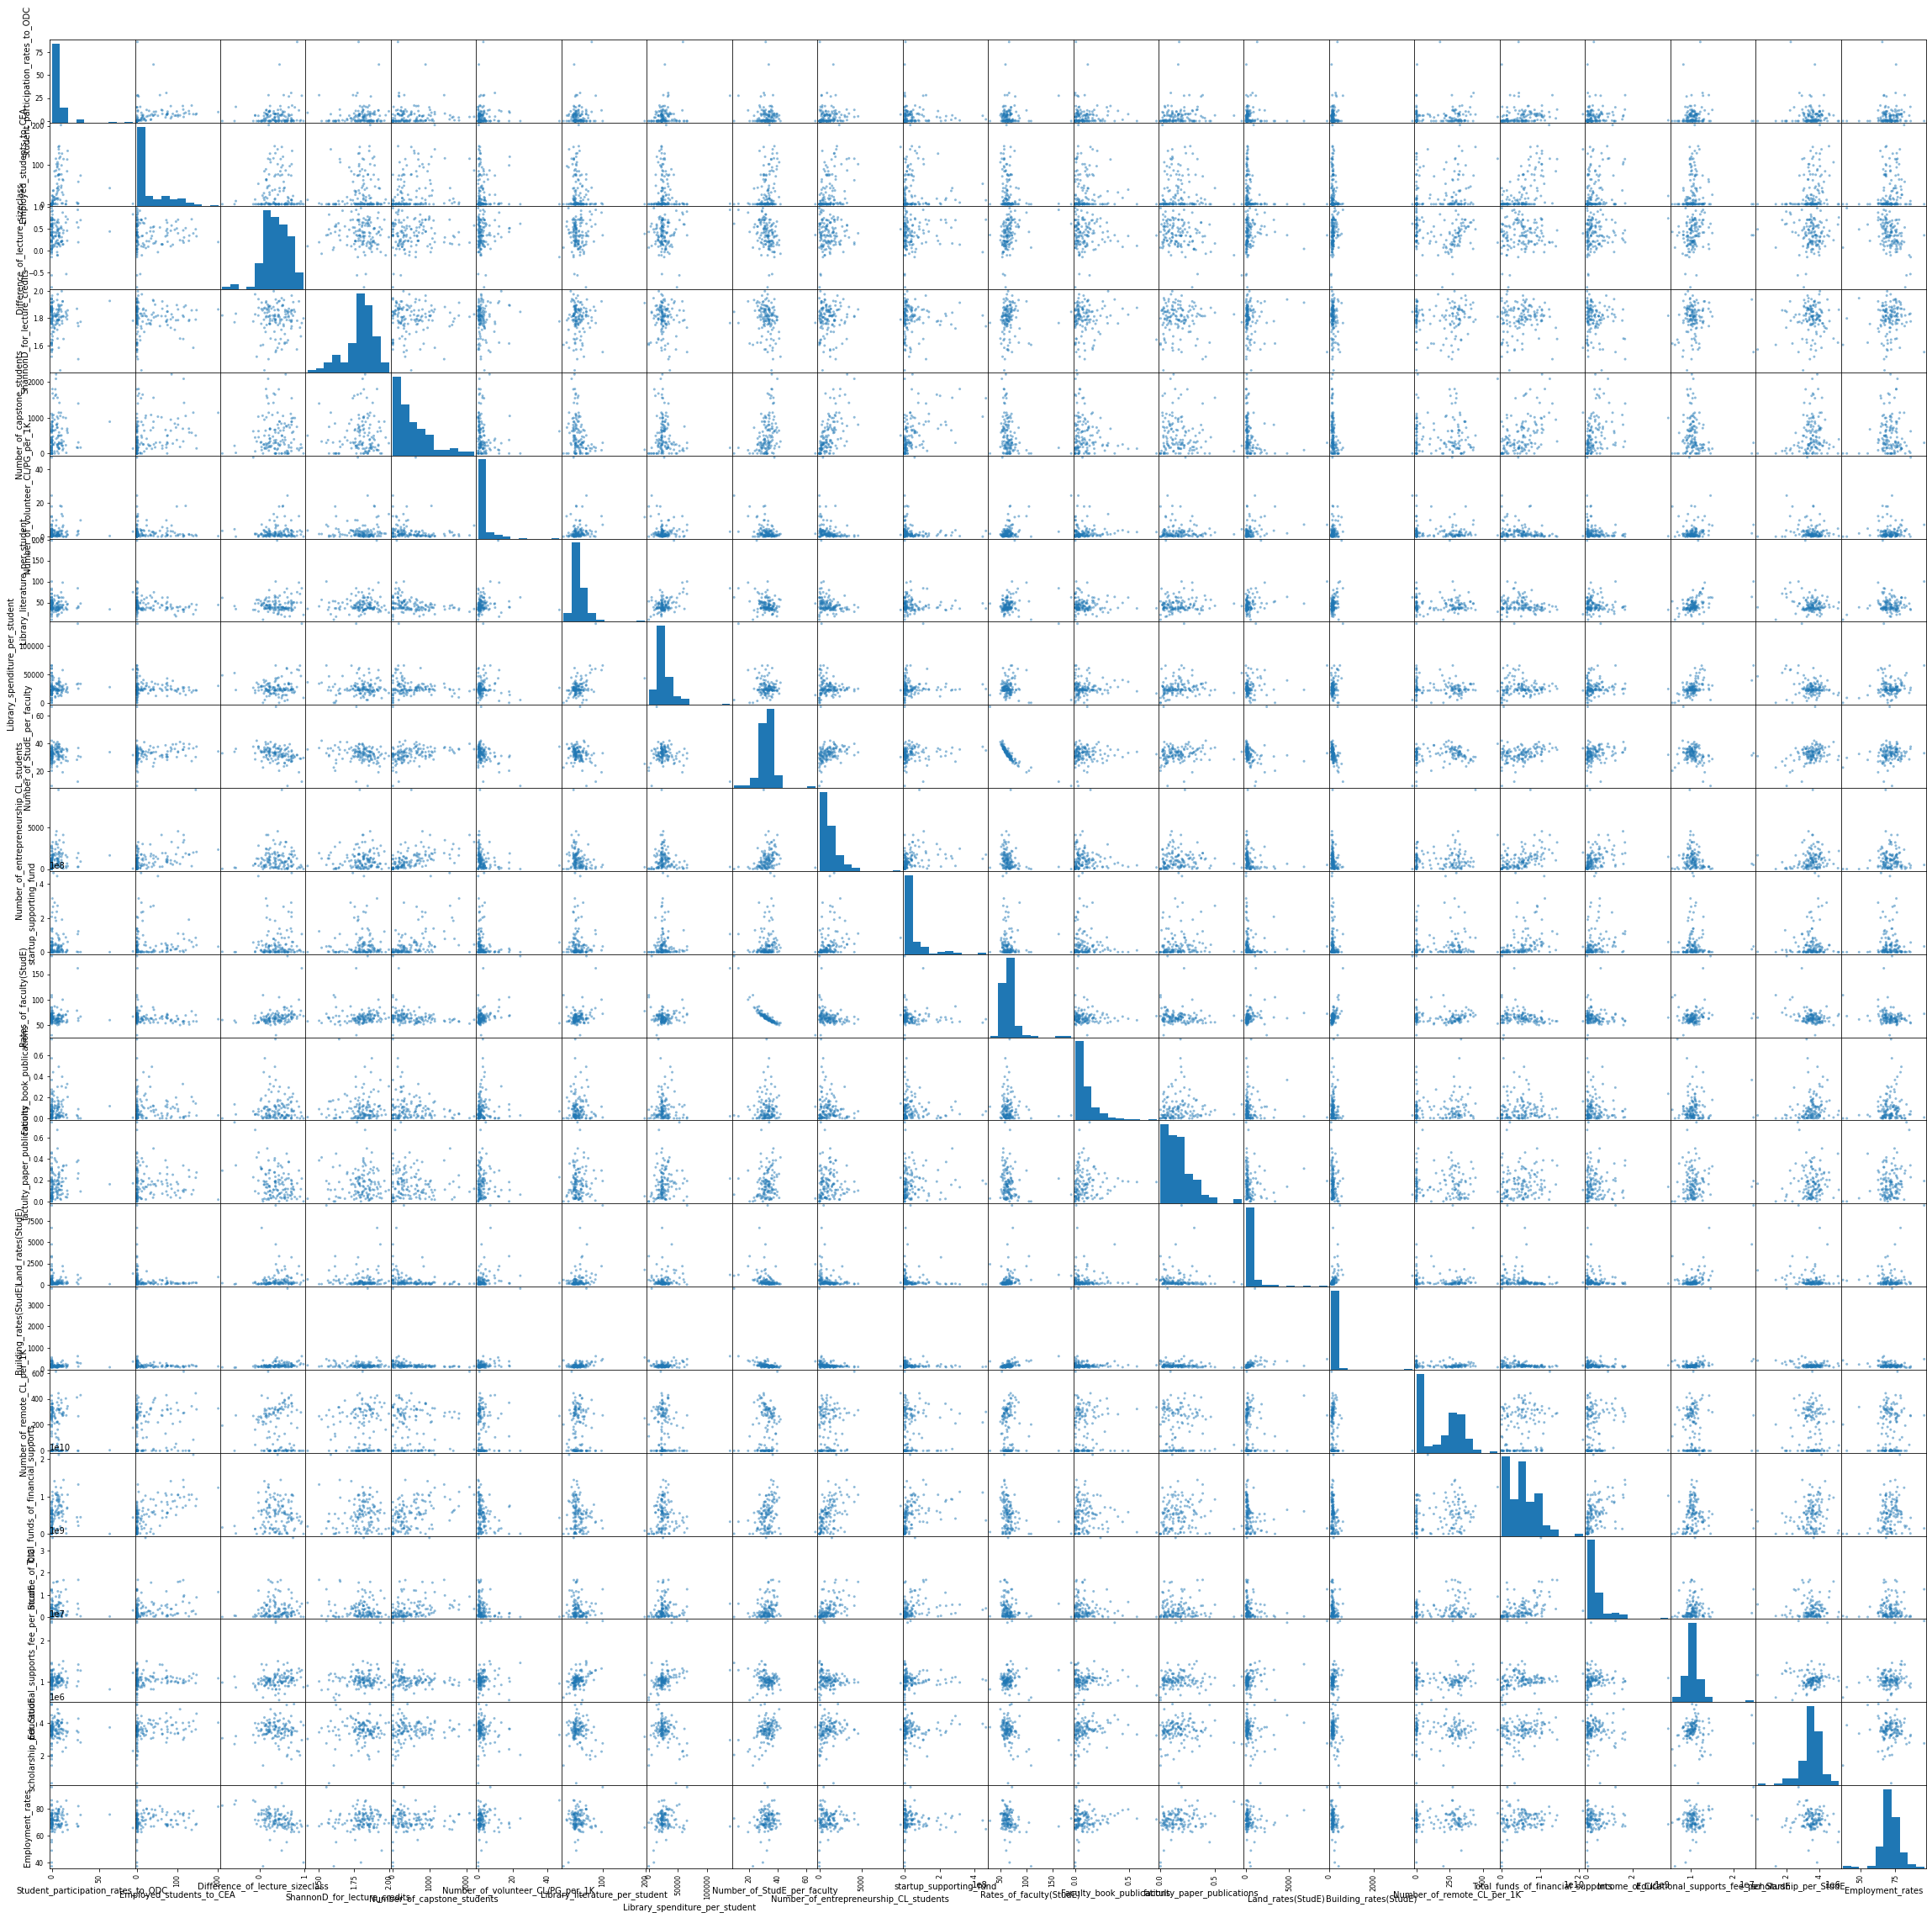

In [ ]:
# 3.5. Investigation of the relationship between the input features

##-------------------------------------------------------------------------------
## 3.4.에서 보여주는 상관성 테이블의 결과를 XY plot 형태로 나타냅니다.
## 두 변수간의 관계를 보다 명확하게 유형화할 수 있습니다.
##-------------------------------------------------------------------------------

scatter_matrix(df, figsize=(40,40))
plt.show()

Text(0, 0.5, 'Frequency')

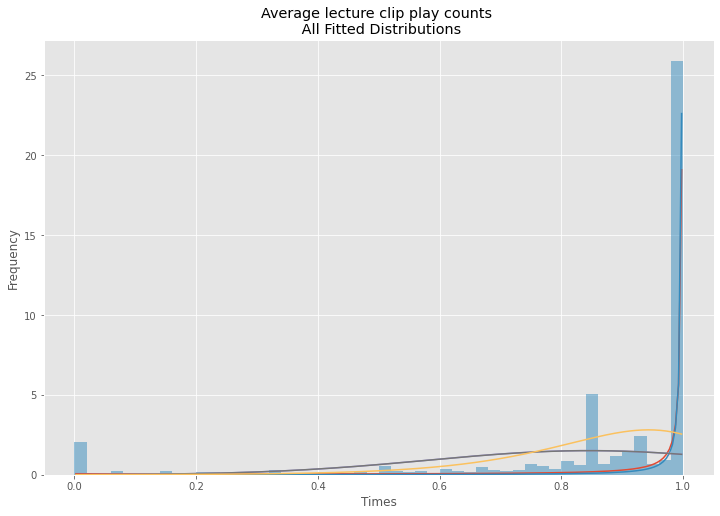

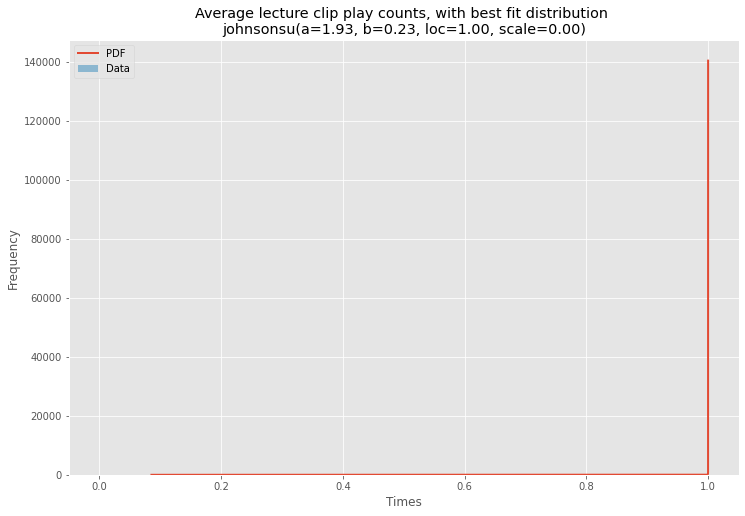

In [ ]:
# 3.6. Fitting data distribution

##-------------------------------------------------------------------------------
## 이 스크립트는 각 입력변수들의 분포를 근사할 수 있는 최적의 확률밀도함수를
## 도출해주는 기능입니다. 
##-------------------------------------------------------------------------------

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [st.johnsonsb, st.johnsonsu, st.lognorm, st.norm, st.weibull_min]

## ------------------------------------------------------------------------------------------------
## 아래 박스는 이 분석 스크립트에서 활용 가능한 모든 종류의 분포근사 함수들입니다.
## 사용 데이터의 양이 적으면 (1000개 내외) 한꺼번에 분석이 가능하지만,
## 데이터 양이 많아지면 근사결과가 잘 나오지 않습니다. 주의하여 사용하시기 바랍니다.
# -------------------------------------------------------------------------------------------------
#DISTRIBUTIONS = [        
#        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
#        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
#        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
#        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
#        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
#        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
#        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
#        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
#        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
#        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
#   ]
# ----------------------------------------------------------------------------------------------------------------

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
df_dist = pd.Series(df.Assign_submission_rates)               # 분포를 확인하고자 하는 변수명 입력
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = df_dist.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(df_dist, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Average lecture clip play counts \n All Fitted Distributions')     # 분석 대상 입력변수 명칭으로 교체
ax.set_xlabel(u'Times')                                      # 분석 대상 입력변수의 특징에 따라 수정
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
df_dist.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Average lecture clip play counts, with best fit distribution \n' + dist_str)   # 분석 대상 입력변수 명칭으로 교체
ax.set_xlabel(u'Times')                                                                       # 분석 대상 입력변수의 특징에 따라 수정
ax.set_ylabel('Frequency')

#ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
#ax.set_xlabel(u'Temp. (°C)')
#ax.set_ylabel('Frequency')

# 4. 초기모델 구축을 통한 입력변수의 영향성 검토
상기의 스크립트를 통해 데이터의 특성을 분석하였으면, 이 스크립트를 실행하면 성능을 최대한 보장하면서 모형의 복잡성을 낮추는데 도움이 되는 다양한 정보를 얻을 수 있습니다. 즉, 분석 대상이 되는 변수 (여기서는 학생의 교과목 성적)에 좀 더 큰 설명력을 갖는 입력변수 (input feature)들을 탐색하고, 그 변수들을 중심으로 초기모형을 개발할 수 있는 정보를 제공합니다.

## 4.1. Data loading
이 스크립트 문서에서 활용할 데이터를 Google Drive에서 불러오는 스크립트입니다.

## 4.2. Temporary model training
각 입력변수가 성적데이터 예측에서 얼마나 중요하게 영향을 미치는지 확인하기 위하여 임시모델을 구축하는 과정입니다. 이 과정에서 학습시킬 때 지속적인 RMSE 개선이 없으면 모형 학습을 중지시키도록 설정해 두었습니다.

## 4.3. Examination of simple input feature importance
4.1.에서 개발한 임시모형을 이용하여, 성적을 예측하는데 사용한 입력변수들의 영향성을 도식화합니다.

## 4.4. Examination of permuted input feature importance
Permutation 방식은 입력데이터로 학습한 모형에게 변조한 입력데이터를 제공함으로써 예측성이 낮아지는 정도를 추정하는 방식입니다. 예를 들면, 성적을 예측하기 위해 활용한 여러 개의 입력변수들 중 하나를 선택한 뒤, 이 변수에 들어있는 값들을 무작위로 뒤섞어서 입력합니다. 만약 이 변수가 성적 예측에 중요한 영향을 미치고 있다면, 기존의 데이터와 다르게 뒤섞어서 입력할 경우 예측이 잘 안되는 현상이 발생할 것입니다. 예측이 안되는 정도가 크면 클수록 성적은 그 변수에 더 강하게 의존적이라 볼 수 있습니다.

## 4.5. Shapley value calculation
Shapley value는 2012년 노벨 경제학생을 수상한 Lloyd Shapley가 창안한 기여도 계산방식입니다. 특정 작업을 둘 이상의 존재가 함께 협엽해서 만들어갈 때, 각자의 기여도를 계산하는 방식입니다. 머신러닝에서는, 특정 입력변수가 포함되었을 때와 그렇지 않을 때의 모형 예측력을 분석하여 해당 변수의 중요도를 평가하는데 활용합니다. 4.3.의 permuation방식과 비슷한 결과가 나오지만, 접근 방식은 전혀 다릅니다.

## 4.6. Shapley vadlue distribution
Shapley value를 입력변수별로 일일이 다 계산해서 하나의 그림으로 보여주는 기능입니다.

## 4.7. Shapley value dependence
하나의 입력변수가 가지고 있는 데이터의 크기에 따라 shapley value가 어떻게 변화하는지 보여줍니다. 이 때 shapley value 기준으로 다음으로 중요한 변수의 값의 크기와 함께 비교할 수 있도록 정보를 제공해줍니다.

In [ ]:
# 4.1. Data loading

##------------------------------------------------------------------------------------------
## 이 스크립트 전체에서 활용할 학습자 데이터를 Google Drive에서 불러옵니다.
##------------------------------------------------------------------------------------------
 
data=df 
y=data['Employment_rates']                       # data에서 성적 데이터인 Employment_rates를 별도로 추출하여 y에 저장함
X=data.drop(['Employment_rates'], axis=1)        # data에서 성적 데이터인 Employment_rates를 제외한 나머지 데이터를 추출하여 X에 저장함
X_train, X_test, y_train, y_test = train_test_split(X, y, test_.,size=0.25, shuffle=True)   # X, y 데이터를 이용하여 학습 및 테스트용 자료를 구축함

In [ ]:
# 4.2. Temporary model training

##------------------------------------------------------------------------------------------
## 불러온 데이터를 이용해서 임시로 활용할 모형을 학습시킵니다.
##------------------------------------------------------------------------------------------
xgbm_ifimp=xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators=10000,
                                gamma = 1, min_child_weight=1, colsample_bytree=1,
                                max_depth=5)  # 모든 hyper-parameter는 default로 두고 학습시키기 / 만약 GPU 사용 활성화하였다면 tree_method = 'gpu_hist' 문구를 모형구성에 포함시키기, tree_method = 'gpu_hist'
xgbm_ifimp.fit(X_train,y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],         
         eval_metric=["rmse"],
         verbose=100,
         early_stopping_rounds=400)     # 모형학습과정에서 성능개선이 없다면 early stop시킴


# 아래는 더 다양한 parameter를 사용할 때 활용할 수 있도록 남겨둔 것임
# hpspace={'max_depth': hp.quniform("max_depth", 3, 10, 1),
#        'gamma': hp.uniform ('gamma', 1,9),
#        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#        'n_estimators': 180,
#        'seed': 0

[0]	validation_0-rmse:63.9273	validation_1-rmse:64.3908
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 400 rounds.
[100]	validation_0-rmse:0.402	validation_1-rmse:4.69245
[200]	validation_0-rmse:0.40197	validation_1-rmse:4.69247
[300]	validation_0-rmse:0.40197	validation_1-rmse:4.69247
[400]	validation_0-rmse:0.40197	validation_1-rmse:4.69247
Stopping. Best iteration:
[44]	validation_0-rmse:1.87942	validation_1-rmse:4.49598



XGBRegressor(gamma=1, max_depth=5, n_estimators=10000,
             objective='reg:squarederror')

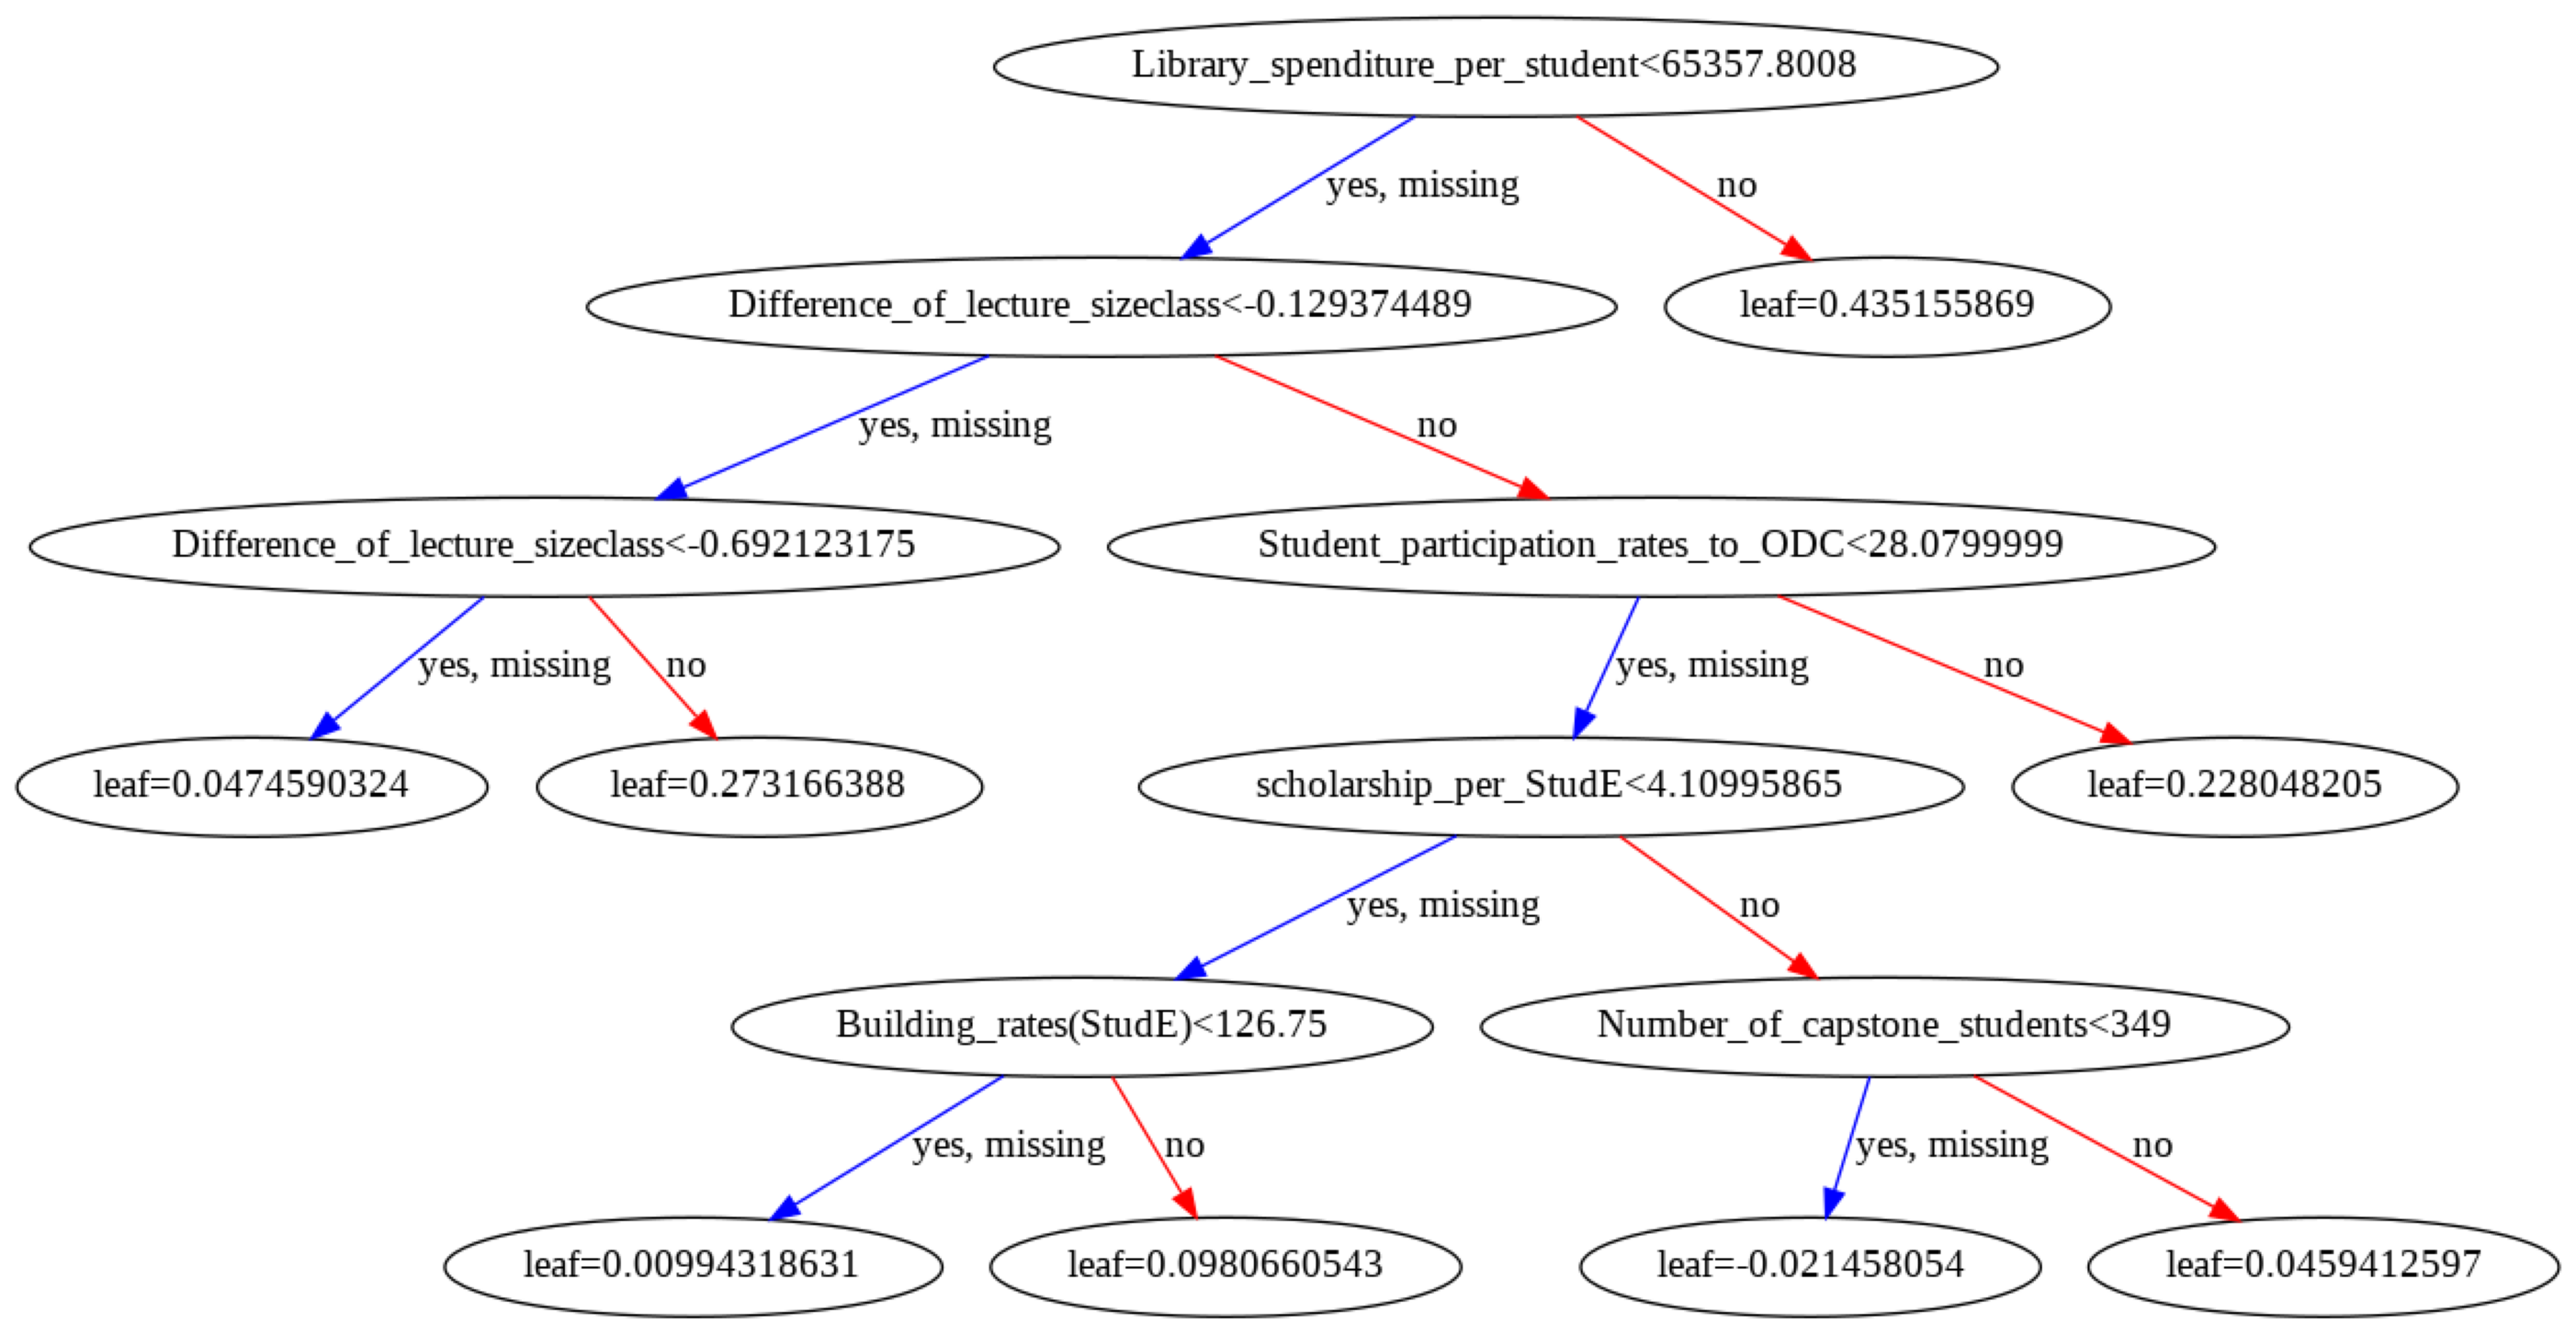

In [ ]:
from xgboost import plot_tree
plt.rcParams["figure.figsize"] = (50,50)
#plot_tree(xgb_model_production)
plot_tree(xgbm_ifimp, num_trees = xgbm_ifimp.get_booster().best_iteration)
plt.show()

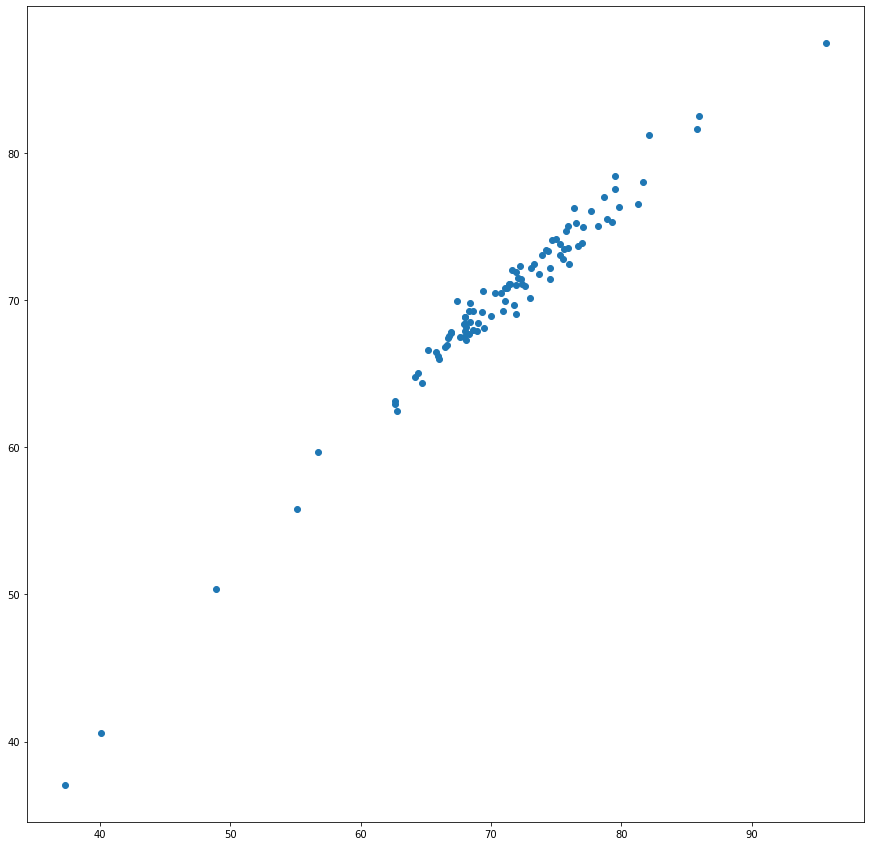

In [ ]:
tr_pred = xgbm_ifimp.predict(X_train)
plt.rcParams["figure.figsize"] = (15,15)
plt.scatter(y_train, tr_pred)

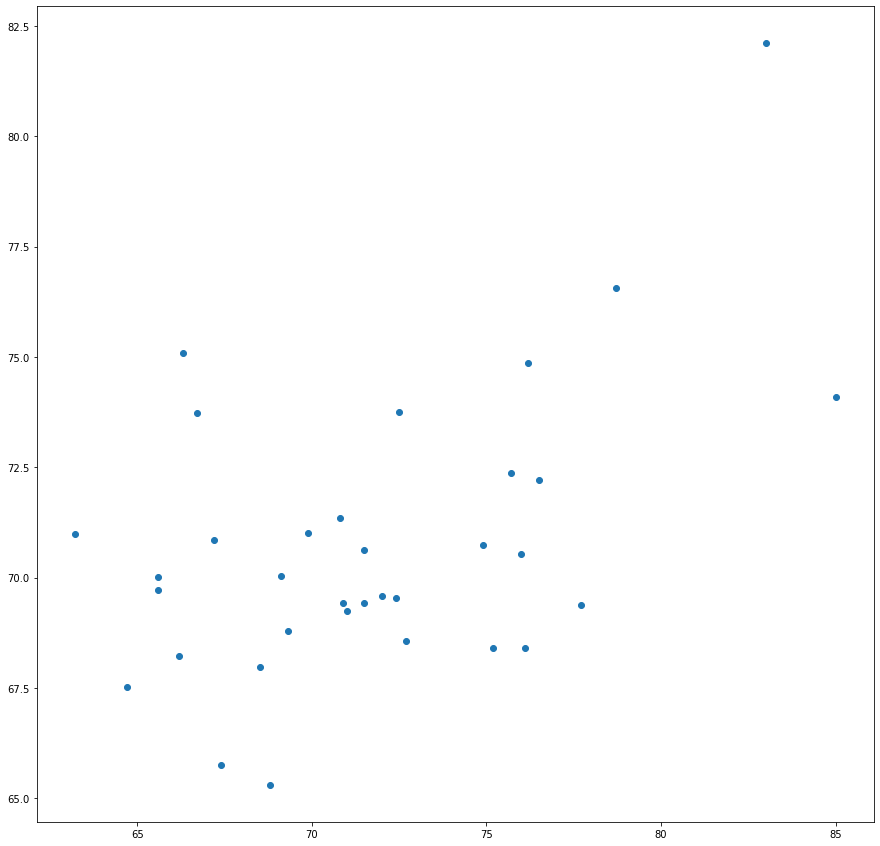

In [ ]:
test = xgbm_ifimp.predict(X_test)
plt.rcParams["figure.figsize"] = (15,15)
plt.scatter(y_test, test)

Text(0.5, 0, 'XGBoost Feature Importance')

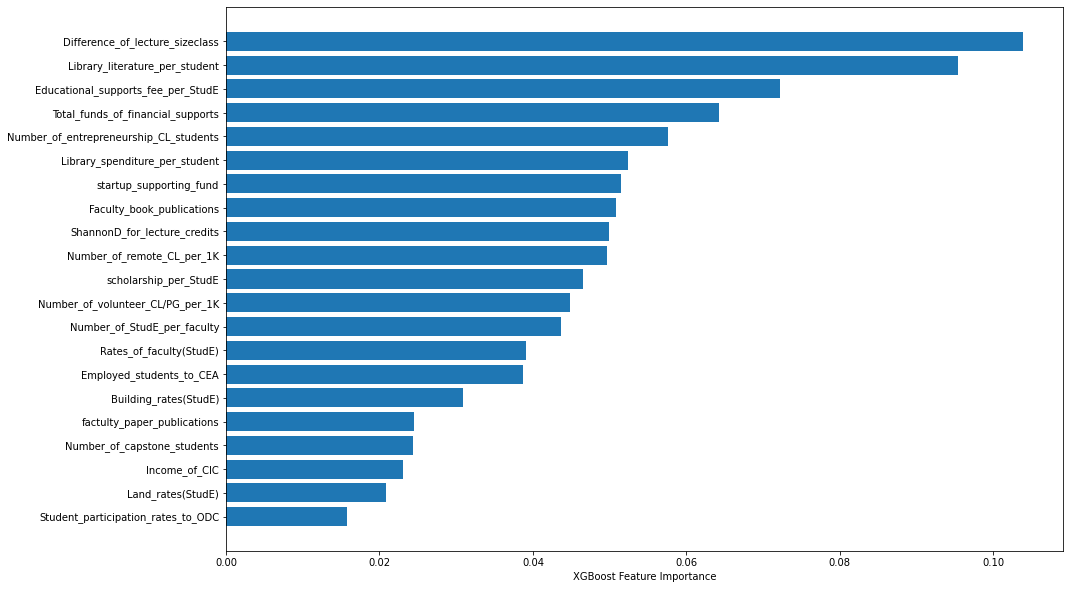

In [ ]:
# 4.3. Examination of simple input feature importance

##------------------------------------------------------------------------------------------
## 4.1에서 개발한 임시모형을 이용하여 단순 입력변수 중요도 파악하는 스크립트로
## 중요도순으로 정렬된 막대그래프 생성
##------------------------------------------------------------------------------------------

xgbm_ifimp.feature_importances_                # 개발한 임시모형으로 입력변수 중요도 값 생성
feature_names=np.array(X_train.columns)        # 학습에 활용한 입력데이터의 변수 제목 추출
sorted_idx = xgbm_ifimp.feature_importances_.argsort()    # 입력변수를 중요도 순으로 정렬
plt.figure(figsize=(15,10))                               # 빈 그림판 생성
plt.barh(feature_names[sorted_idx], xgbm_ifimp.feature_importances_[sorted_idx])     # 입력변수 중요도로 가로 막대그래프 그리기
plt.xlabel("XGBoost Feature Importance")                  # X축 제목 지정

Text(0.5, 0, 'Permutation Importance')

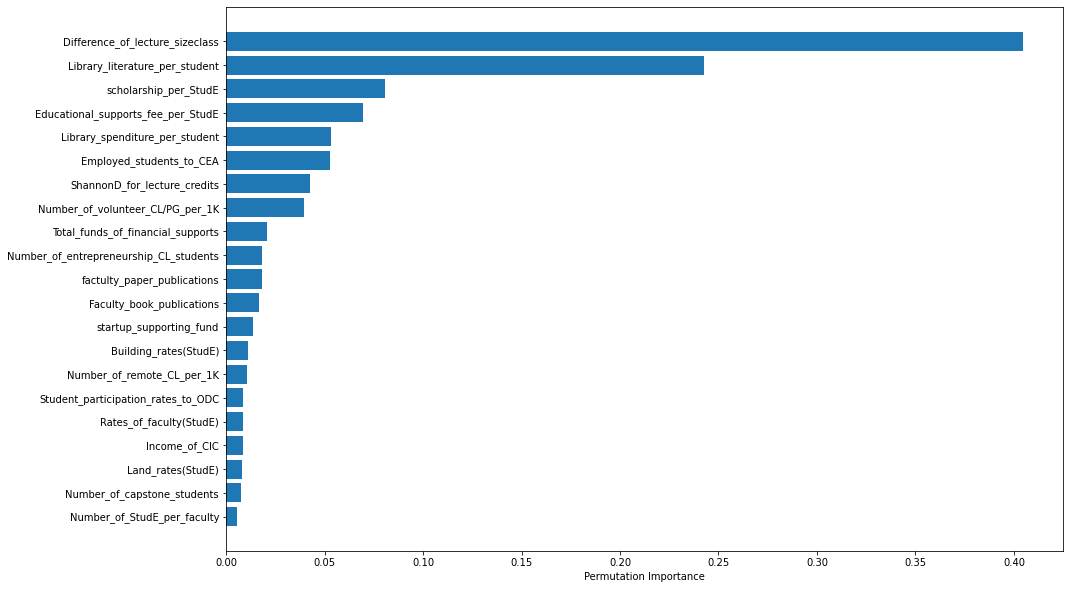

In [ ]:
# 4.4. Examination of permuted input feature importance

##------------------------------------------------------------------------
## Permutation importance는 모형이 사용하는 입력변수들 중 하나를
## 무작위로 뒤섞어서 입력함으로써, 그 모형에서 들어오는 데이터의 정보를
## 교란시켜 모형의 예측성능이 얼마나 감소하는지를 확인하는 방식으로
## 변수의 중요성을 검토합니다.
##------------------------------------------------------------------------

perm_importance = permutation_importance(xgbm_ifimp, X_train, y_train)    # 주어진 학습데이터에 대한 permutation importance 계산
sorted_idx = perm_importance.importances_mean.argsort()                   #  permutation importance를 크기 순으로 정렬
plt.figure(figsize=(15,10))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
# 4.5. Shapley value calculation

##------------------------------------------------------------------------
## Shapley value는 특정 변수가 모형의 성능에 얼마나 기여하는지 분석하는
## 방식입니다. 앞선 분석방식과 비슷한 결과가 나타나지만, 계산 방식은
## 전혀 다릅니다.
##------------------------------------------------------------------------

explainer = shap.TreeExplainer(xgbm_ifimp)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

NameError: ignored

In [ ]:
# 4.6. Shapley vadlue distribution

##------------------------------------------------------------------------
## 각 입력변수를 구성하는 값들의 크기에 따라 모형의 성능에 미치는 영향을
## 하나의 그래프로 그려서 보여주는 기능입니다.
##------------------------------------------------------------------------

shap.summary_plot(shap_values, X_train)

NameError: ignored

In [ ]:
# 4.7. Shapley value dependence

##------------------------------------------------------------------------
## 입력변수별의 값에 따라 shapley value가 어떻게 변하는지 보여줍니다.
## 이 때 다음으로 기여도가 높은 값의 크기와 함께 비교할 수 있게
## 정보를 좀 더 많이 제공해줍니다.
##------------------------------------------------------------------------

shap.dependence_plot("Ex_scholarship", shap_values, X_train)

NameError: ignored


# 5. 주요 입력변수 활용한 두 번째 초기모형구축 (down-sizing experiment)
이 스크립트는 전체 입력변수를 사용했을 때에 비해 일부만 사용하면 모형성능이 어떻게 바뀌는지 비교한 뒤, 적절한 입력변수를 선택하도록 하고 있습니다. 따라서, 5.1. 과정으로 전체 입력변수를 이용하여 모형을 만들고, 5.2.에서 입력변수의 조합에 따른 성능을 검토한 뒤 적절한 조합을 찾습니다. 다시 5.1.을 실행시켜 해당 조합으로 모형을 학습시킨 뒤 5.3. 등등 나머지 과정을 진행합니다.

## 5.1. Model creation for forward input feature selection protocol
4.6.까지의 절차는 개발한 모형을 이용하여 입력변수의 중요도를 상대적으로 평가하는 과정입니다. 여기서부터는 실제 중요도가 높은 입력변수만을 이용해서 모형을 구축하는 과정입니다. 이 스크립트는 입력변수를 하나씩, 두개씩, 단계별로 수를 늘여가며 모형의 성능을 비교하는 기능을 제공합니다.

## 5.2. Model performance comparision based on the input feature selection
5.1.에서 모형을 만드는 과정에서 기록으로 남은 모형의 성능차이를 그림으로 보여주는 기능입니다.

## 5.3. Feature identification and test data preparation
성능, 모형구조 복잡성 등 측면에서 상대적으로 가장 우위에 있는 모형이 활용한 변수의 목록을 확인합니다. 그리고 지금까지 모형을 개발하면서 사용한 입력데이터에서 해당 입력변수들만 추려내어 새로운 입력데이터를 구성합니다.

## 5.4. Examination of model performance based on reduced number of input features
5.3.에서 확인한 '선택된 입력변수'만으로 모형을 만들고, 그 성능을 값으로 기록합니다.

## 5.5. Examination of model performance with all input features
5.4.에서 활용한 모형개발환경과 똑같은 조건에서 모든 입력변수를 이용하여 모형을 만든 뒤 5.4. 결과와 비교합니다.

In [ ]:
# 5.1. Model creation for forward input feature selection protocol

##------------------------------------------------------------------------
## 모든 입력변수를 하나씩, 두개씩 반복적으로 넣어보면서 모형의 성능이
## 얼마나 개선되는지를 보여주기 위해 새로운 모형을 학습시키는 과정입니다.
##------------------------------------------------------------------------

xgbm_sfs=xgboost.XGBRegressor(objective ='reg:squarederror',
                          n_estimators=100, n_jobs=-1,
                          early_stopping_rounds=400, tree_method='gpu_hist')  # 모든 hyper-parameter는 default로 두고 학습시키며, 생각보다 시간이 오래 걸리므로 GPU기능 사용 필수입니다. tree_method = 'gpu_hist'

sfs1 = sfs(xgbm_sfs, k_features=21, forward=True, floating=False, verbose=2, scoring='neg_mean_squared_error', cv=5)   # n_feature_to_select -> k_features로 변경

sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

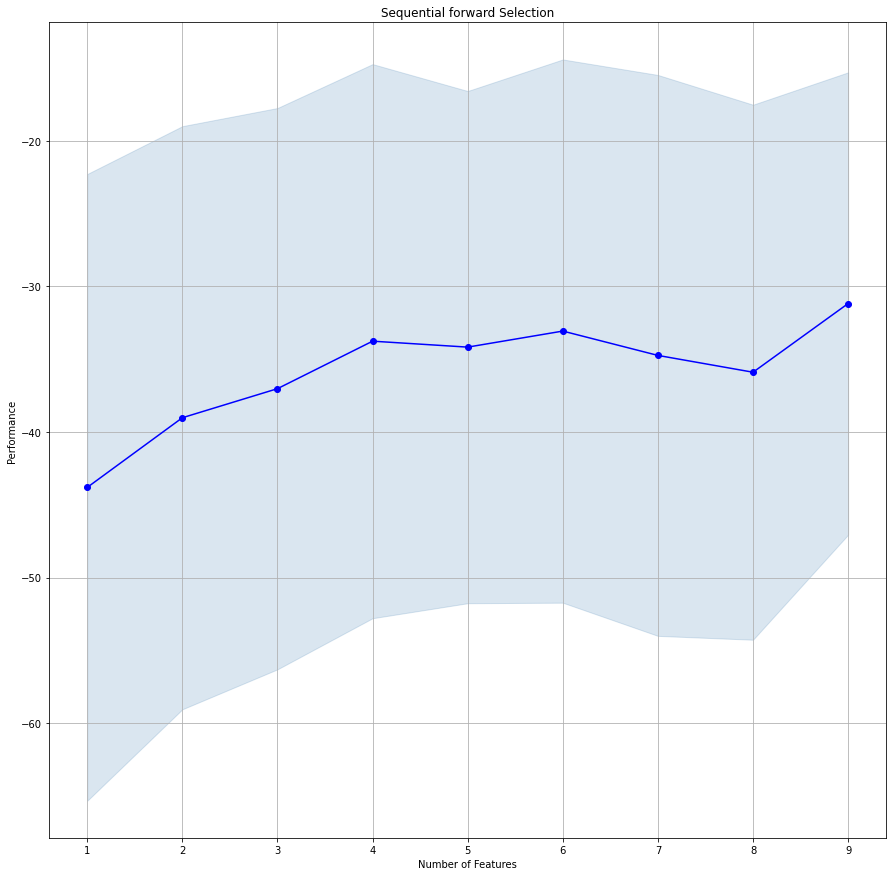

In [ ]:
# 5.2. Model performance comparision based on the input feature selection

##------------------------------------------------------------------------
## 4.7.에서 개발한 새로운 모형에 입력변수를 사용한 종류별로 성능이
## 어떻게 변했는지 그림으로 보여주는 기능입니다.
##------------------------------------------------------------------------

fig = plot_sequential_feature_selection(sfs1.get_metric_dict(), kind='std_dev')
#plt.ylim([-200, 0])
plt.title('Sequential forward Selection')
plt.rcParams["figure.figsize"] = (15,15)
plt.grid()
plt.show()

In [ ]:
# 5.3. Feature identification and test data preparation

##------------------------------------------------------------------------
## 4.8.에서 알게 된, '상대적으로 가장 좋은 성능'을 보여주는 모형에
## 어떤 입력변수가 포함되었는지 확인합니다.
##------------------------------------------------------------------------

feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)                        # 입력변수의 이름이 아닌 인덱스 번호가 나오는데, 제일 첫번째 변수의 인덱스 번호가 0입니다. 즉, 0, 1, 2,... 순으로 나옵니다.

X_tr_sel=X_train.iloc[:, feat_cols]     # 앞서 준비한 X 데이터로부터 중요도가 높다고 판단한 변수만 추려서 X_tr_sel에 저장합니다.
X_tst_sel=X_test.iloc[:, feat_cols]     # 마찬가지로 중요도가 높다고 판단한 변수만 추려서 X_tst_sel에 저장합니다.

[1, 3, 10, 13, 14, 15, 16, 19, 20]


In [ ]:
feat_cols = [1, 3, 10, 13, 14, 15, 16, 19, 20]

X_tr_sel=X_train.iloc[:, feat_cols]     # 앞서 준비한 X 데이터로부터 중요도가 높다고 판단한 변수만 추려서 X_tr_sel에 저장합니다.
X_tst_sel=X_test.iloc[:, feat_cols] 

In [ ]:
# 5.4. Examination of model performance based on reduced number of input features

##------------------------------------------------------------------------
## 4.9..에서 추출해서 만든 X, y 데이터로 새로운 모형을 하나 구축하고,
## 이 모형의 성능이 모든 입력변수를 사용하는 모형에 비해 얼마나 
## 차이가 나는지 비교합니다.
## 성능은 RMSE 값으로 도출합니다. 4.11.에서 만들 모형과 비교합니다.
##------------------------------------------------------------------------

xgbm_sel=xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators=500, n_jobs=-1, early_stopping_rounds=100)  # 모든 hyper-parameter는 default로 두고 학습시키기
xgbm_sel.fit(X_tr_sel, y_train)

y_sel_tr_pred = xgbm_sel.predict(X_tr_sel)
acc_sel_tr=np.sqrt(mean_squared_error(y_train, y_sel_tr_pred))
print('Training accuracy on selected features = %.3f' % (acc_sel_tr))

y_sel_tst_pred = xgbm_sel.predict(X_tst_sel)
acc_sel_tst=np.sqrt(mean_squared_error(y_test, y_sel_tst_pred))
print("Testing accuracy on selected features: %.3f" % (acc_sel_tst))

Training accuracy on selected features = 0.012
Testing accuracy on selected features: 6.316


In [ ]:
# 5.5. Examination of model performance with all input features

##------------------------------------------------------------------------
## 4.10. 모형의 성능을 비교할 수 있도록, 이 과정에서 사용한 모델링
## 설정환경을 따르면서 모든 입력변수를 활용한 모형을 하나 만들고,
## 그 성능값을 RMSE 형태로 도출합니다.
##------------------------------------------------------------------------

xgbm_all=xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators=500, n_jobs=-1, early_stopping_rounds=100)  # 모든 hyper-parameter는 default로 두고 학습시키기 , tree_method = 'gpu_hist'
xgbm_all.fit(X_train, y_train)

y_all_tr_pred = xgbm_all.predict(X_train)
acc_all_tr = np.sqrt(mean_squared_error(y_train, y_all_tr_pred))
print('Training accuracy on total features: %.3f' % (acc_all_tr))

y_all_tst_pred = xgbm_all.predict(X_test)
acc_all_tst = np.sqrt(mean_squared_error(y_test, y_all_tst_pred))
print('Testing accuracy on total features: %.3f' % (acc_all_tst))

Training accuracy on total features: 0.002
Testing accuracy on total features: 4.621


# 6. 입력변수 선택결과에 바탕한 Hyper-parameter 최적화

## 6.1. Bayesian optimization for hyperparameters
XGBoost의 학습방식을 결정하는데 다양한 hyper-parameter가 관여합니다. 이 파라미터 값들을 적절하게 조정하면 모형의 성능기 개선됩니다. 이 스크립트에서는 5단계에서 확인한 입력변수들을 이용하여 production model을 구축할 때, XGBoost 모형의 성능을 극대화할 수 있는 hyper-parameter 조합을 Bayesian 방식으로 탐색합니다.

## 6.2. Production model development
선택된 입력변수와 최적화한 hyper-parameter로 세팅한 production 모형을 새로 만듭니다.

## 6.3. Saving the production model and its related datasets
6.2.에서 학습한 모형과, 학습하는데 사용한 각종 데이터들 (X, y 데이터들)을 Google Drive에 저장합니다.
- 6.3.1. Best-model loading: 과거에 저장한 모형을 다시 활용해야 한다면 처음부터 학습시킬 필요 없이 이 스크립트를 이용해서 저장한 모형을 불러와서 작업하면 됩니다.


In [ ]:
# 6.1. Bayesian optimization for hyperparameters

##------------------------------------------------------------------------
## 이 스크립트는 XGBoost 모형을 구축할 때 모형의 작동방식을 설정하는
## Hyper-parameter들을 Bayesian 방식으로 자동 설정하는 기능을 제공합니다.
## 파라미터의 값을 잡을 때는 앞선 임시모형에서 사용하기로 한
## 선택된 입력변수들만 활용합니다.
##------------------------------------------------------------------------

hpspace={'max_depth': hp.quniform('max_depth', 3, 15, 1),
         'eta': hp.uniform('eta', 0.01, 0.2),
         'min_child_weight' : hp.quniform('min_child_weight', 0, 2, 0.1),
         'subsample' : hp.uniform('subsample', 0.5, 1),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
         'reg_alpha' : hp.quniform('reg_alpha', 0, 0.5, 0.1),
         'scale_pos_weight' : hp.uniform('scale_pos_weight', 0, 1)}
 
# 아래는 더 다양한 parameter를 사용할 때 활용할 수 있도록 남겨둔 것임
# hpspace={'max_depth': hp.quniform("max_depth", 3, 10, 1),
#        'gamma': hp.uniform ('gamma', 1,9),
#        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#        'n_estimators': 180,
#        'seed': 0
#    }
 
def objective(params):
  params = {'max_depth': int(params['max_depth']),
            'eta': params['eta'],
            'min_child_weight': params['min_child_weight'],
            'subsample': params['subsample'],
            'reg_alpha': params['reg_alpha'],
            'colsample_bytree': params['colsample_bytree'],
            'scale_pos_weight': params['scale_pos_weight']}
  xgb_model=xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators = 200,  tree_method = 'gpu_hist', n_jobs = -1, **params, early_stopping_rounds=100)  # 노트 설정에서 runtime 환경을 GPU로 잡은 뒤, xgboost의 parameter에 tree_method = 'gpu_hist' 추가하면 됨 / 
  best_score = cross_val_score(xgb_model, X_tr_sel, y_train,
                               scoring='neg_mean_squared_error',
                               cv=10).mean()
  loss = 1 - best_score
  return loss
 
# 아래는 상기의 더 다양한 parameter를 사용할 때 모형 속에  parameter를 집어넣는 방식을 담고 있음.
#  def objective(hpspace):
#  xgb_model=xgboost.XGBRegressor(
#                    n_estimators =hpspace['n_estimators'], max_depth = int(hpspace['max_depth']), gamma = hpspace['gamma'],
#                    reg_alpha = int(hpspace['reg_alpha']),min_child_weight=int(hpspace['min_child_weight']),
#                    colsample_bytree=int(hpspace['colsample_bytree']))
 
best = fmin(fn=objective, space=hpspace,
            max_evals=10,
            rstate=np.random.RandomState(777),
            algo=tpe.suggest)
print(best)

100%|██████████| 10/10 [02:31<00:00, 15.17s/it, best loss: 68.4389170468888]
{'colsample_bytree': 0.9749942460049568, 'eta': 0.14076060712248237, 'max_depth': 13.0, 'min_child_weight': 1.6, 'reg_alpha': 0.2, 'scale_pos_weight': 0.3980511773587152, 'subsample': 0.5956166481249425}


In [ ]:
# 6.2. Production model development

##------------------------------------------------------------------------
## 6.1.에서 탐색완료한 parameter 조합을 자동으로 모형에 반영하여
## 최종 production model을 만들 때 사용하는 스크립트입니다.
## 최적화된 파라미터들은 자동으로 새 모형이 흡수해서 학습합니다.
##------------------------------------------------------------------------

for key, value in best.items():                  # 최적 parameter값이 저장된 dict인 best에서 키와 값을 추출하도록 시행
    best['max_depth']=int(best['max_depth'])     # 정수로 입력해야 할 parameter인 max_depth의 값을 여러 키 중에서 찾아서 정수화한 뒤 다시 max_depth의 v값으로 입력
    #best['n_estimators']=int(best['n_estimators'])

xgb_model_production=xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators=1000, n_jobs = -1, early_stopping_rounds = 100, **best)  # 새롭게 만들 하나의 모형에서 사용하는 parameter들이 저장된 best를 직접 활용해서 parameter 지정    
xgb_model_production.fit(X_tr_sel,y_train)

XGBRegressor(colsample_bytree=0.9749942460049568, early_stopping_rounds=100,
             eta=0.14076060712248237, max_depth=13, min_child_weight=1.6,
             n_estimators=1000, n_jobs=-1, objective='reg:squarederror',
             reg_alpha=0.2, scale_pos_weight=0.3980511773587152,
             subsample=0.5956166481249425)

In [ ]:
# 6.3. Saving the production model and its related datasets

##------------------------------------------------------------------------
## 이 스크립트는 6.2.에서 학습완료한 xgb_model_production의 모형을
## best_model.bin이라는 이름으로 구글드라이브에 저장합니다.
## 이와 함께, best_model을 만드는 과정에서 활용한 각종 데이터들 역시
## 같은 디렉토리에 저장해둡니다.
##------------------------------------------------------------------------

model_name = "best_model.bin"
pickle.dump(xgb_model_production, open(dongju_data_mining_dir+model_name, "wb"))

X_tr_sel.to_excel(dongju_data_mining_dir+'X_train_sel.xlsx', sheet_name='Sheet1')
X_tst_sel.to_excel(dongju_data_mining_dir+'X_test_sel.xlsx', sheet_name='Sheet1')
y_train.to_excel(dongju_data_mining_dir+'y_train.xlsx', sheet_name='Sheet1')
y_test.to_excel(dongju_data_mining_dir+'y_test.xlsx', sheet_name='Sheet1')

#xgb_model_production.save_model(dongju_data_mining_dir+'best_model.bin')
#xgb_model_production.dump_model(dongju_data_mining_dir+'best_model_raw.txt',dongju_data_mining_dir+'best_model_featmap.txt')

In [ ]:
## 6.3.1. Best-model loading

##------------------------------------------------------------------------
## 이 스크립트는 6.3.에서 저장한 모형을 불러오는 기능을 합니다.
## 단, 불러온 모형을 이용해서 분석할 때는, 모형객체 이름을 잘 확인해서
## 사용하시기 바랍니다.
##------------------------------------------------------------------------

xgb_model_production = pickle.load(open(dongju_data_mining_dir+"best_model.bin","rb"))

X_tr_sel = pd.read_excel(dongju_data_mining_dir + "X_train_sel.xlsx")
X_tst_sel = pd.read_excel(dongju_data_mining_dir + "X_test_sel.xlsx")
y_train = pd.read_excel(dongju_data_mining_dir + "y_train.xlsx")
y_test = pd.read_excel(dongju_data_mining_dir + "y_test.xlsx")

#bst_model_production = xgb.Booster({'nthread': 4})  # init model
#bst_model_production.load_model('best_model.bin')  # load data

#new_model.best_ntree_limit
#with open(dongju_data_mining_dir+'xgb_model0.bin','rb') as selected_model:  # xgb_model 뒤의 숫자를 바꿔서 최상의 결과를 보여주는 모형을 불러오기
#  xgb_model_production= pickle.load(selected_model)

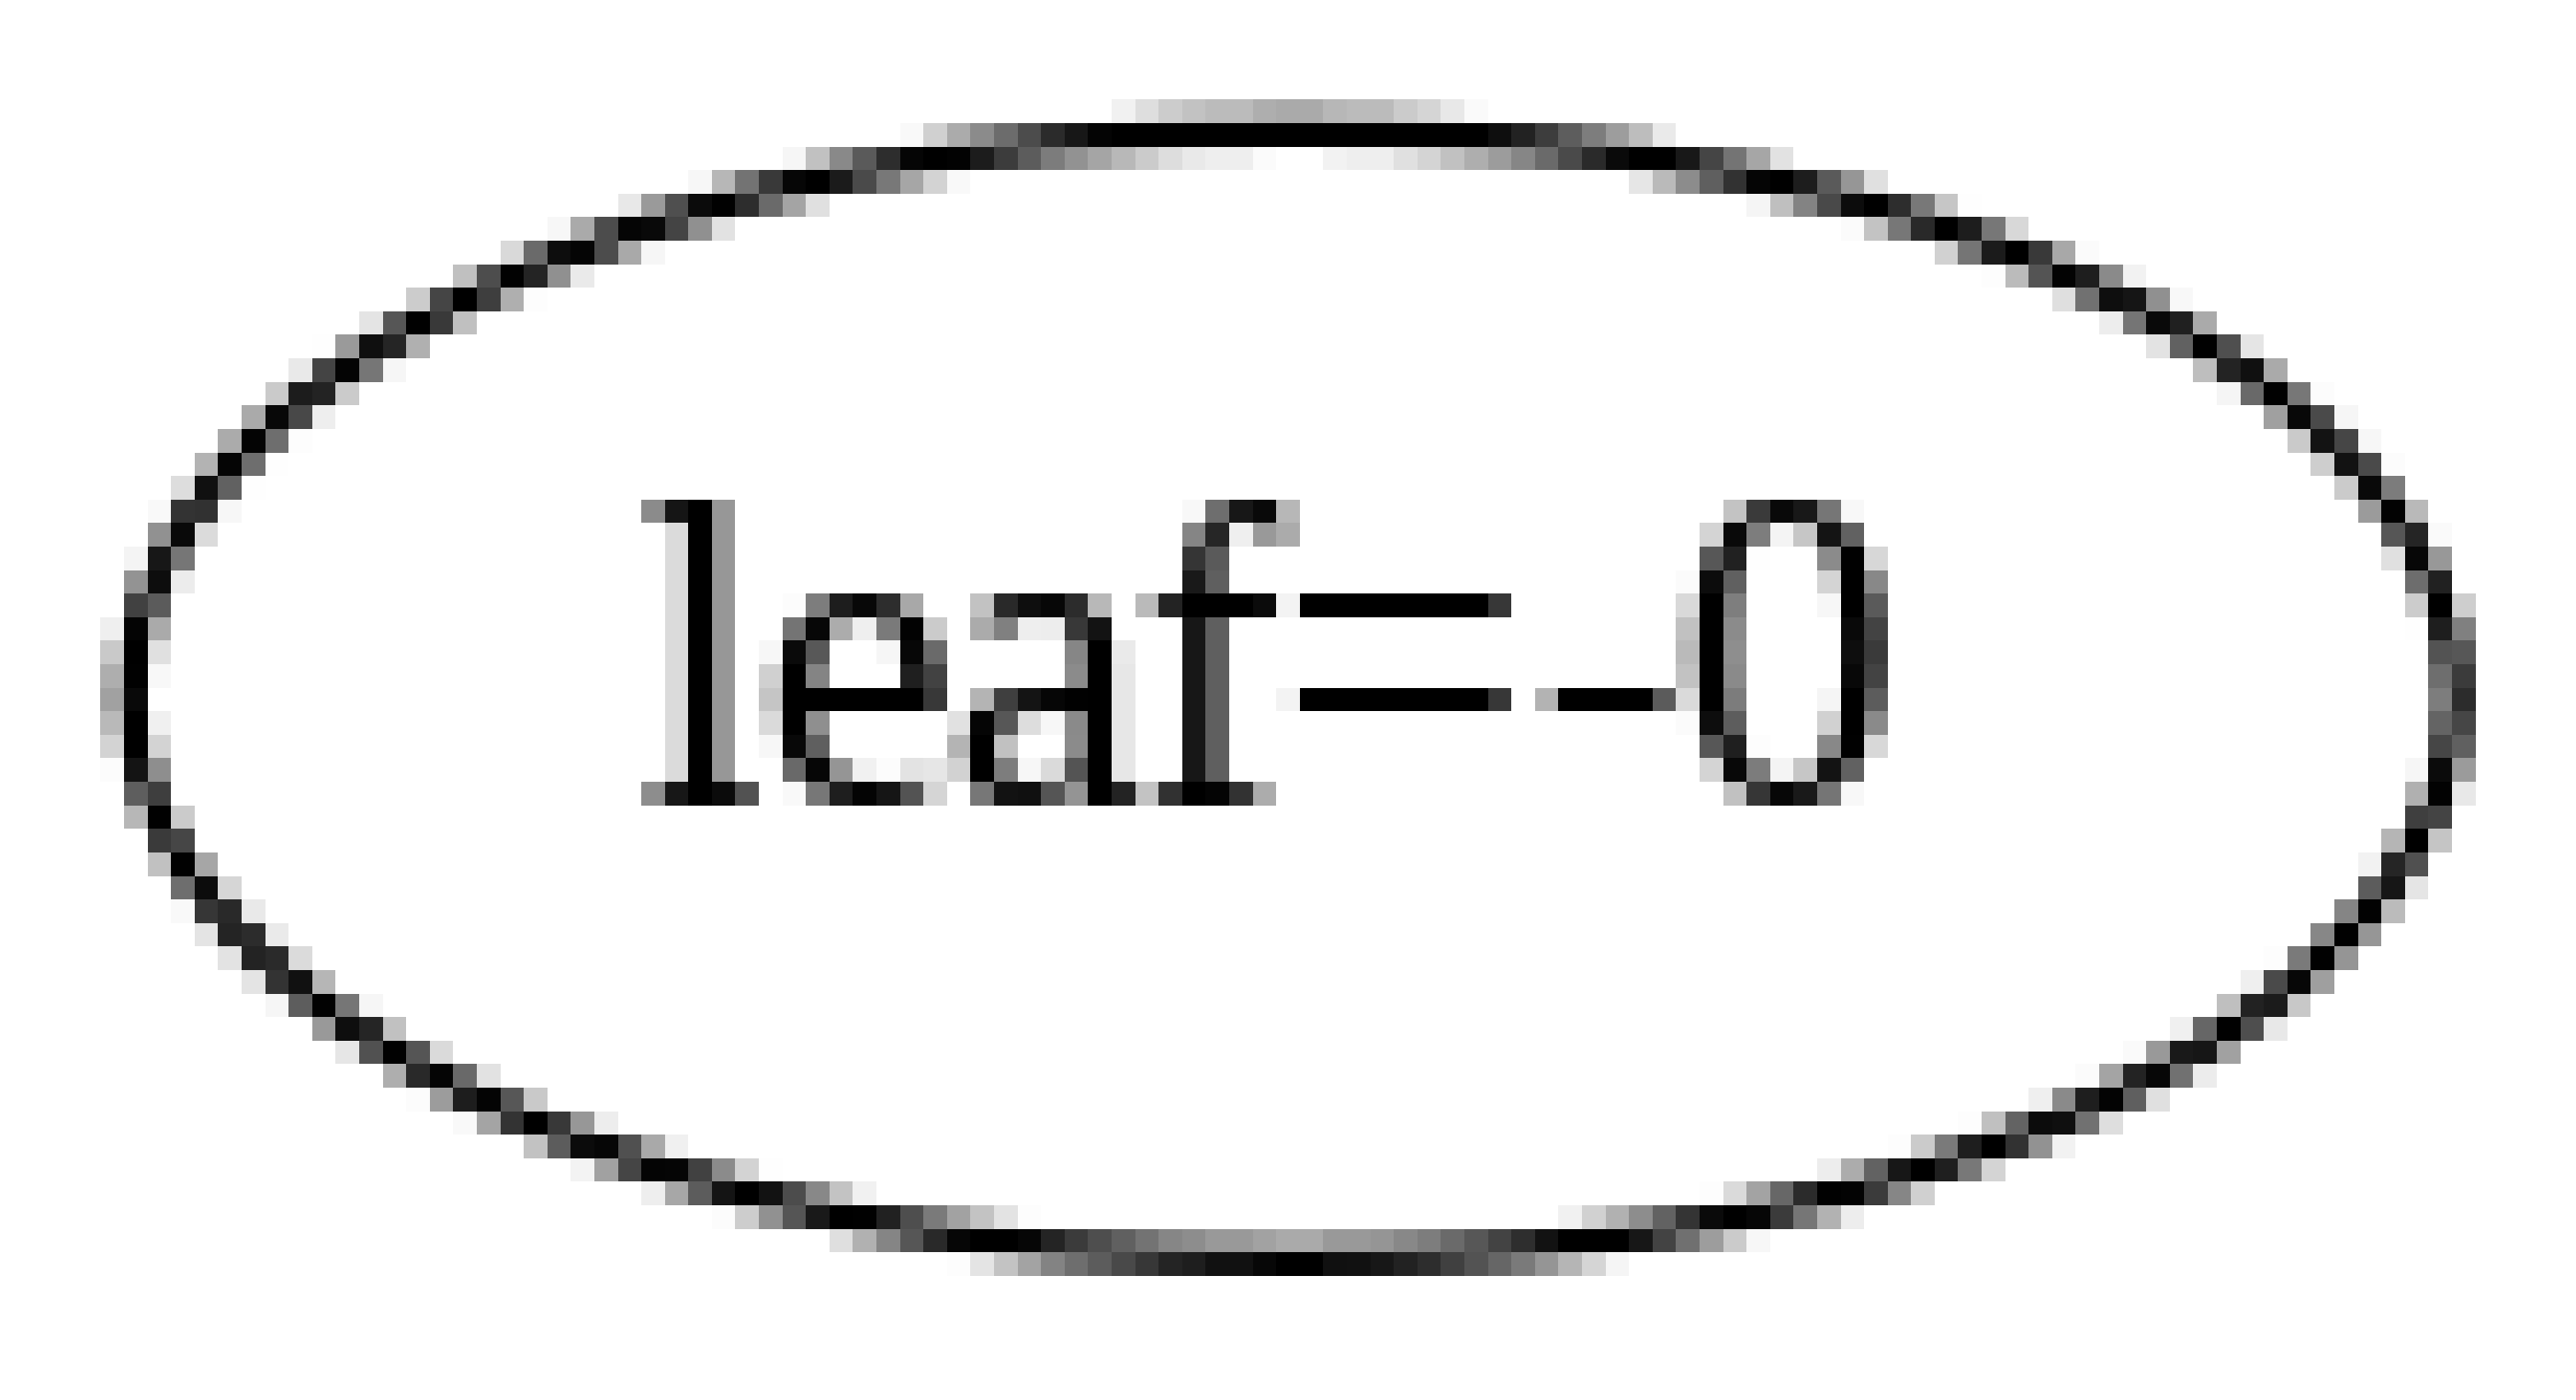

In [ ]:
# 6.4. Model structure investigation

##------------------------------------------------------------------------
## 이 스크립트는 최종적으로 완성한 best model의 구조를 확인하는 기능을
## 재공합니다. 스크립트 실행 후 나타나는 모형 구조를 통해서 입력변수들이
## 어떻게 다른 변수와 연관되는지 확인 가능합니다.
##------------------------------------------------------------------------

# Model tree investigation

from xgboost import plot_tree
plt.rcParams["figure.figsize"] = (50,50)
#plot_tree(xgb_model_production)
plot_tree (xgb_model_production, num_trees = xgb_model_production.get_booster().best_iteration)
plt.show()

# 7. 최종모형의 입력변수 영향성 검토

이 과정은 최종모형에 활용된 입력변수들이 예측한 성적 값에 어떤 영향을 미치는지 모의하는 과정입니다.

## 7.1. Training data predictability
최종 구축한 모형에 training data를 입력했을 때 모형이 만들어내는 예측값이 얼마나 실측값에 잘 맞는지 XY plot으로 확인합니다.

## 7.2. Testing data predictability
학습데이터와 마찬가지로, 최종구축 모형을 이용해서 test data를 예측시키는 과정입니다. 마찬가지로 XY plot을 그려냅니다.


0.9999561912580357
0.05183589396882758


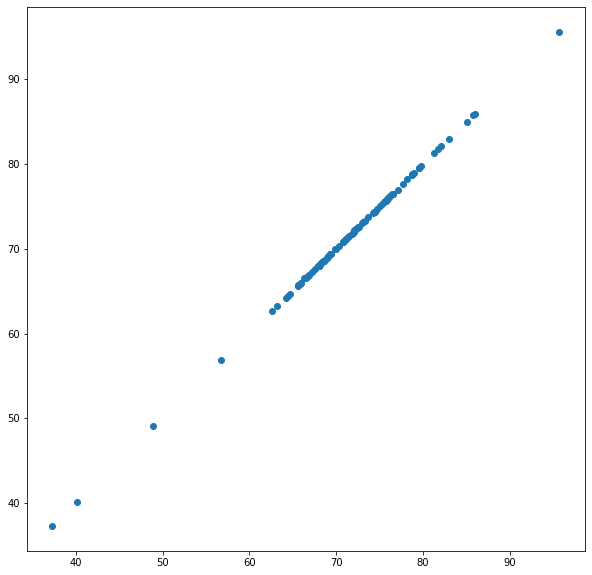

In [ ]:
# 7.1. Training data predictability

##------------------------------------------------------------------------
## 학습완료된 최종 production 모형을 이용하여 학습자료에 대한 예측성능을
## XY plot으로 표현합니다. 
##------------------------------------------------------------------------

Credits_train_hat=xgb_model_production.predict(X_tr_sel)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_train, Credits_train_hat)
rsq_tr_sel = r2_score(y_train, Credits_train_hat)
rmse_tr_sel = np.sqrt(mean_squared_error(y_train, Credits_train_hat))

print(rsq_tr_sel)
print(rmse_tr_sel)

-1.7043203623085823
8.241630909151052


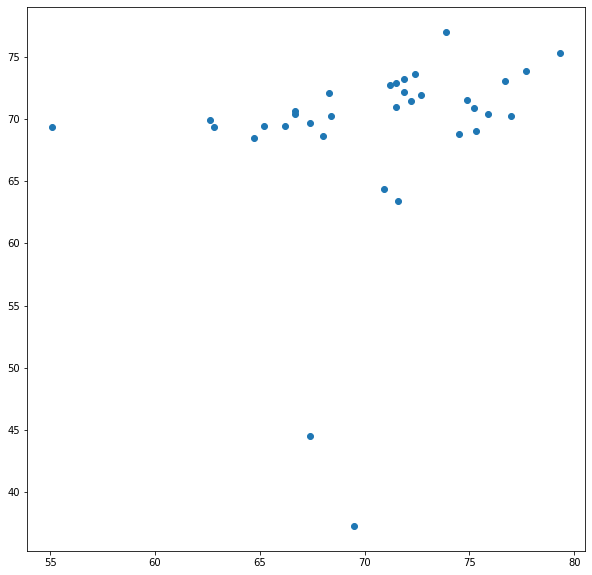

In [ ]:
# 7.2. Testing data predictability

##------------------------------------------------------------------------
## 학습완료된 최종 production 모형을 이용하여 테스트 자료에 대한 예측성능을
## XY plot으로 표현합니다. 
##------------------------------------------------------------------------

Credits_test_hat=xgb_model_production.predict(X_tst_sel)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_test, Credits_test_hat)
rsq_tst_sel = r2_score(y_test, Credits_test_hat)
rmse_tst_sel = np.sqrt(mean_squared_error(y_test, Credits_test_hat))

print(rsq_tst_sel)
print(rmse_tst_sel)

# 8. 학생성적 시뮬레이션
이 과정은 주어진 입력데이터를 이용하여 학생의 성적이 입력변수에 어떻게 반응하는지 확인하는 과정입니다.

## 8.1. MIP data preparation
MIP는 여러 가지 입력변수 중 하나의 변수를 변화시키고 나머지 변수를 평균으로 두었을 때 모형이 어떻게 반응하는지 확인하는 과정입니다. 여기서는 미리 준비된 MIP 데이터를 불러오는 과정입니다.

## 8.2. MIP calculation
MIP 데이터를 모형에 입력시켜 성적 값을 예측시키는 과정입니다. 계산된 결과는 엑셀파일로 저장하여 구글드라이브에 보관하도록 되어 있습니다.

## 8.3. Simulation data loading
시뮬레이션은 하나의 입력변수의 값을 10단계로 변화시키고 나머지 입력변수들은 최대최소값 사이에서 무작위로 10만개 데이터를 생산하여 합친 뒤, 모형에 이 데이터를 입력하여 모형 예측값이 10단계 변화하는 변수의 조건에 따라 어떻게 분포하는지 확인하는 과정입니다. 여기서는 시뮬레이션 데이터를 불러옵니다.

## 8.4. Implementing simulation
불러온 시뮬레이션 데이터를 모형에 입력시켜 계산한 뒤, 결과값을 엑셀 파일로 저장해서 구글드라이브에 담는 과정입니다. 이 과정은 상당히 많은 시간이 걸리므로 여유를 가지고 작업하시기 바랍니다.


In [ ]:
# 8.1. MIP data preparation

##------------------------------------------------------------------------
## 미리 준비한 MIP 데이터를 불러오는 과정입니다.
##------------------------------------------------------------------------

mip=pd.read_excel(dongju_data_mining_dir+"MIP_raws.xlsx")
mip.head()

Access_rates  runningtime_max  ...  Ex_scholarship  In_scholarship
0           0.0       210.491879  ...        0.425293        0.090049
1           0.1       210.491879  ...        0.425293        0.090049
2           0.2       210.491879  ...        0.425293        0.090049
3           0.3       210.491879  ...        0.425293        0.090049
4           0.4       210.491879  ...        0.425293        0.090049

[5 rows x 13 columns]

In [ ]:
# 8.2. MIP calculation

##------------------------------------------------------------------------
## 불러온 MIP 데이터를 이용해서 MIP 결과를 계산하는 과정입니다.
##------------------------------------------------------------------------

Preds_mip = xgb_model_production.predict(mip)
Preds_mip_df = pd.DataFrame(Preds_mip)
Preds_mip_df.to_excel(dongju_data_mining_dir+'MIP_output.xlsx', sheet_name='Sheet1')

In [ ]:
# 개발중입니다. 아직 작동하면 안됩니다.
# 8.3.1. Important parameters setting & data preparation for simulation

out_data_dir = dongju_data_mining_dir +'output/'
# True인 경우 csv파일로 결과를 저장함.
# CSV가 excel보다 더 빨리 저장이 되어 주로 CSV로 저장함.
print_option = True
rdn_num = 100000
linnum = 10

X_tr_sel = pd.read_excel(dongju_data_mining_dir + "X_train.xlsx")

mimmax_df = pd.DataFrame(X_tr_sel.max(), columns=['max'])
mimmax_df['min'] = X_tr_sel.min()
mimmax_df['nunique'] = X_tr_sel.nunique()
mimmax_df['dtypes'] = X_tr_sel.dtypes

In [ ]:
# 개발중입니다. 아직 작동하면 안됩니다.
# 8.3.2. Ranged random number generation 100,000

df_rdn = pd.DataFrame()

for col_name in mimmax_df.index:

  if col_name == 'Female':
    df_rdn[col_name] = np.where( df_rdn['Male'] ==0, 1, 0)
  else: 
    if mimmax_df['dtypes'][col_name] == 'float64':
      # 이 구문을 사용시 max값은 제거됨
      df_rdn[col_name] = np.random.rand(rdn_num)*(mimmax_df['max'][col_name]-mimmax_df['min'][col_name]) + mimmax_df['min'][col_name]
    else:
      df_rdn[col_name] = np.random.randint(mimmax_df['min'][col_name], mimmax_df['max'][col_name]+1, size=rdn_num)

if print_option ==True:
  #df_rdn.to_excel(out_data_dir + "df_rdn.xlsx")
  df_rdn.to_csv(out_data_dir + "df_rdn.csv")
df_rdn

SN  Access_rates  ...  Ex_scholarship  In_scholarship
0      11482      0.755475  ...        0.671935        0.354836
1      19556      0.385681  ...        0.452058        0.053624
2       6892      0.528619  ...        0.569782        0.817828
3       3873      0.511657  ...        0.790965        0.872511
4       2380      0.565506  ...        0.222399        0.827094
...      ...           ...  ...             ...             ...
99995  10330      0.589806  ...        0.290575        0.545078
99996  21154      0.415792  ...        0.292887        0.933315
99997  11733      0.827827  ...        0.257419        0.072209
99998  19380      0.816031  ...        0.325380        0.526822
99999  19763      0.491474  ...        0.476404        0.716645

[100000 rows x 14 columns]

In [ ]:
# 개발중입니다. 아직 작동하면 안됩니다.
# 8.3.3. Merge the ranged random numbers

simul = pd.DataFrame()

for idx, col_name in enumerate(mimmax_df.index):

  #if col_name == 'Female' : continue

  # 유니크한 변수의 수가 10개 이상이면 10개로 구분, 그 이하면 그 수대로 구분
  if mimmax_df['nunique'][col_name] > linnum:
    temp_linspace = np.linspace(mimmax_df['min'][col_name], mimmax_df['max'][col_name], linnum)
  else: 
    temp_linspace = np.linspace(mimmax_df['min'][col_name], mimmax_df['max'][col_name], mimmax_df['nunique'][col_name])

  temp_name = 'df_rdn_' + col_name
  globals()[temp_name] = pd.DataFrame()

  for idx, value in enumerate(temp_linspace):
    df_temp = df_rdn.copy()
    df_temp[col_name] = value

    if idx == 0:
      temp_name = df_temp.copy()
    else:
      temp_name = temp_name.append(df_temp)

  if col_name == 'Male': 
    temp_name['Female'] =  np.where( temp_name['Male'] ==0, 1, 0)  
  if col_name == 'Female': 
    temp_name['Male'] =  np.where( temp_name['Female'] ==0, 1, 0)  

  if idx ==0:
    simul = temp_name.copy()
  else:
    simul = simul.append(temp_name)

  # 파일출력
  print('df_rdn_' + col_name + ' done. ' + str(temp_name.shape[0]) + ' rows')
  #print(temp_name.head())
  if print_option == True:
    #temp_name.to_excel(out_data_dir + "df_rdn_" + col_name + ".xlsx")
    temp_name.to_csv(out_data_dir + "df_rdn_" + col_name + ".csv")

if print_option == True:
  #df.to_excel(out_data_dir + "simul.xlsx")
  simul.to_csv(out_data_dir + "simul.csv")  

df_rdn_SN done. 1000000 rows
df_rdn_Access_rates done. 1000000 rows
df_rdn_runningtime_max done. 1000000 rows
df_rdn_runningtime_ave done. 1000000 rows
df_rdn_Assign_deadline_rates done. 1000000 rows
df_rdn_Assign_submission_rates done. 1000000 rows
df_rdn_Quiz_answering_rates done. 1000000 rows
df_rdn_Quiz_overdue_max done. 1000000 rows
df_rdn_Quis_overdue_min done. 1000000 rows
df_rdn_Age done. 1000000 rows
df_rdn_Male done. 200000 rows
df_rdn_Female done. 200000 rows
df_rdn_Ex_scholarship done. 1000000 rows
df_rdn_In_scholarship done. 1000000 rows


In [ ]:
# 개발중입니다. 아직 작동하면 안됩니다.
simul

SN  Access_rates  ...  Ex_scholarship  In_scholarship
0          0.0      0.755475  ...        0.671935        0.354836
1          0.0      0.385681  ...        0.452058        0.053624
2          0.0      0.528619  ...        0.569782        0.817828
3          0.0      0.511657  ...        0.790965        0.872511
4          0.0      0.565506  ...        0.222399        0.827094
...        ...           ...  ...             ...             ...
99995  10330.0      0.589806  ...        0.290575        1.000000
99996  21154.0      0.415792  ...        0.292887        1.000000
99997  11733.0      0.827827  ...        0.257419        1.000000
99998  19380.0      0.816031  ...        0.325380        1.000000
99999  19763.0      0.491474  ...        0.476404        1.000000

[12400000 rows x 14 columns]

In [ ]:
# 8.3. Simulation data loading

##------------------------------------------------------------------------
## 미리 준비한 시뮬레이션 데이터를 불러오는 과정입니다. 데이터의 크기가
## 매우 크기 때문에 불러오는데 시간이 걸립니다.
##------------------------------------------------------------------------

simul=pd.read_excel(dongju_data_mining_dir+"Assign_submission_rates_simul.xlsx")
simul.head()

Access_rates  runningtime_max  ...  Ex_scholarship  In_scholarship
0        0.4010        2186.3686  ...          0.8534          0.0816
1        0.7117         914.4057  ...          0.1411          0.8298
2        0.9257        1756.8863  ...          0.1088          0.2795
3        0.8888        2375.8004  ...          0.0304          0.9600
4        0.0240        2431.3826  ...          0.3444          0.2339

[5 rows x 13 columns]

In [ ]:
# 8.4. Implementing simulation

##------------------------------------------------------------------------
## 시뮬레이션 데이터로 계산을 실시하는 과정입니다. 총 100만개의 데이터를
## 계산하므로 시간이 많이 걸립니다.
##------------------------------------------------------------------------

Preds_simul = xgb_model_production.predict(simul)
Preds_simul_df = pd.DataFrame(Preds_simul)
Preds_simul_df.to_excel(dongju_data_mining_dir+'simul_output.xlsx', sheet_name='Sheet1')